In [31]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
sbn.set()

In [32]:
# Variable
timesteps = 64
batch_size = 2
train_to_val_ratio = 7
units = 32
data_dim = 8
div_class = [-0.5, 0.5]
#div_class = [-0.5, -0.3, -0.1, 0.1, 0.3, 0.5]
num_classes = len(div_class) + 1

In [33]:
def data_load():
    data_dir = '../data/'
    day_index1 = data_dir + '1day/index/2000_2009.csv'
    day_index2 = data_dir + '1day/index/2010_2016.csv'
    data1 = pd.read_csv(day_index1,encoding='gbk', parse_dates=['date'])
    data2 = pd.read_csv(day_index2,encoding='gbk', parse_dates=['date'])
    data = pd.concat([data1, data2])
    data.set_index(['code', 'date'], inplace=True)
    return data

In [108]:
def split_train_validate(data, timesteps, batch_size, query_str):
    match = data_all.query(query_str)
    min_num = int(batch_size) * int(timesteps) 
    size = len(data)
    m = int(size / min_num)
    if m < 1:
        return None
    
    end_num = min_num * m
    print("train set: {0}:{1}".format(0, end_num))
    train = match.iloc[:end_num, :]

    return train

In [35]:
def split_train_validate1(data, timesteps, batch_size, train_to_val_ratio):
    min_test_num = batch_size * timesteps 
    min_train_num = min_test_num * train_to_val_ratio
    
    min_all = min_train_num + min_test_num
    size = len(data)
    if size < min_all:
        return None, None
    
    m = int(size / min_all)
    print("train set: {0}:{1}".format(0, min_train_num*m))
    train = data.iloc[:min_train_num*m, :]
    
    test_begin = min_train_num * m
    test_end = int(size / min_test_num) * min_test_num
    print("test set: {0}:{1}".format(test_begin, test_end))
    test = data.iloc[test_begin:test_end, :]
    return train, test

In [37]:
def data_clean(data):
    new_data = pd.DataFrame()
    for column in ['open', 'high', 'low', 'close']:
        new_data[column] = data[column] / 10000.0

    # new_data.dropna(inplace=True)
    return new_data

In [46]:
# 阴阳线
def stick_type(x):
    stick_type = -1
    if x['close'] >= x['open']:
        stick_type = 1
    return stick_type

# 上引线
def up_line(x):
    return x['high'] - x[['open','close']].max()

# 下引线
def down_line(x):
    return x[['open','close']].min() - x['low']

# 实体长度
def body_size(x):
    return x['close'] - x['open']

def range_to_class(x):
    cls = []
    size = len(div_class)
    n = -1;
    if x < div_class[0]:
        n = 1
    elif x >= div_class[size-1]:
        n = size + 1
    else:    
        for i in range(0, size-1):
            if div_class[i] <= x < div_class[i+1]:
                n = i + 2
                # print("n=", n)
                break
    if n >= 0:
        for i in range(0, size+1):
            if i == n - 1:
                cls.append(1.0)
            else:
                cls.append(0.0)
    else:
        print(x)
        print("Error: n less than 0")
    return cls

In [56]:
def data_transform(data):
    new_data = pd.DataFrame()
    pre_close = data['close'].shift(1)
    for column in ['open', 'high', 'low', 'close']:
        new_data[column] = (data[column] - pre_close) / pre_close
    # new_data.dropna(inplace=True)
        
    # change percentage enlarge
    new_data = new_data * 100.0
        
    # add new feature
    new_data['stick_type'] = new_data.apply(stick_type, axis=1)
    new_data['up_line'] = new_data.apply(up_line, axis=1)
    new_data['down_line'] = new_data.apply(down_line, axis=1)
    new_data['close_open'] = new_data.apply(body_size, axis=1)
        
    # classes
    new_data['class'] = new_data['close'].shift(-1)
    # new_data.dropna(inplace=True)
    new_data.fillna(0, inplace=True)
    new_data['class']= new_data['class'].map(range_to_class)
        
    # new_data.dropna(inplace=True)
    return new_data

In [59]:
def data_reform(data, batch_size, timesteps):
    print("shape: {0}".format(data.shape))
    size = len(data)
    if size % (int(batch_size) * int(timesteps)) != 0:
        print("data size not match, size: {0}, batch_size: {1}, timesteps: {2}".format(size, batch_size, timesteps))
        return None, None
   
    X, Y0 = data[:, :-1], data[:, -1]
    
    X = X.reshape((-1, timesteps, X.shape[1]))
    
    Y = np.array([np.array(y) for y in Y0])
    
    Y = Y.reshape((-1, timesteps, Y.shape[1]))
    
    print("X.shape: {0} Y.shape: {1}".format(X.shape, Y.shape))
    
    return X, Y

In [83]:
idxes = data_all.index.get_level_values('code').unique()

In [84]:
idxes

Int64Index([   300, 990009, 990017, 990018, 990019, 990020, 990021, 990022,
            990023, 990025,
            ...
            399989, 399990, 399991, 399992, 399993, 399994, 399995, 399996,
            399997, 399998],
           dtype='int64', name='code', length=742)

In [98]:
data_all.query('date>"20150101"')

wind_code   name       time      open      high       low  \
code   date                                                                    
300    2015-01-05  000300.SH  沪深300  150049000  35660888  36690422  35515104   
       2015-01-06  000300.SH  沪深300  150049000  36084279  36832256  35872311   
       2015-01-07  000300.SH  沪深300  150056000  36209239  36711903  36016977   
       2015-01-08  000300.SH  沪深300  150058000  36500729  36599448  35520997   
       2015-01-09  000300.SH  沪深300  150053000  35475740  36897531  35363949   
       2015-01-12  000300.SH  沪深300  150052000  35315148  35605271  34613219   
       2015-01-13  000300.SH  沪深300  150054000  35064508  35501580  34947679   
       2015-01-14  000300.SH  沪深300  150057000  35229071  35472424  34715600   
       2015-01-15  000300.SH  沪深300  150059000  35017193  36041205  34822697   
       2015-01-16  000300.SH  沪深300  150049000  36162475  36621576  36012575   
       2015-01-19  000300.SH  沪深300  150057000  34140129  34972517  33309808   
       2015-01-20  000300.SH  沪深300  150056000  33367926  34192043  33256814   
       2015-01-21  000300.SH  沪深300  150056000  34204905  35577939  34094295   
       2015-01-22  000300.SH  沪深300  150059000  35510515  35767559  35200526   
       2015-01-23  000300.SH  沪深300  150054000  35820876  36278062  35486261   
       2015-01-26  000300.SH  沪深300  150052000  35801179  36116165  35593763   
       2015-01-27  000300.SH  沪深300  150047000  36140379  36162581  35100171   
       2015-01-28  000300.SH  沪深300  150056000  35472389  35833122  35123928   
       2015-01-29  000300.SH  沪深300  150050000  34749149  35055819  34539007   
       2015-01-30  000300.SH  沪深300  150055000  34968846  35142166  34319360   
       2015-02-02  000300.SH  沪深300  150058000  33601931  34072558  33470852   
       2015-02-03  000300.SH  沪深300  150057000  33886024  34417091  33607167   
       2015-02-04  000300.SH  沪深300  150057000  34461440  34768170  33995653   
       2015-02-05  000300.SH  沪深300  150046000  34879505  34879505  33668622   
       2015-02-06  000300.SH  沪深300  150054000  33523298  33740511  32859349   
       2015-02-09  000300.SH  沪深300  150051000  33057335  33765262  32985974   
       2015-02-10  000300.SH  沪深300  150046000  33450769  34071796  33395479   
       2015-02-11  000300.SH  沪深300  150056000  34159767  34456550  34121358   
       2015-02-12  000300.SH  沪深300  150049000  34353608  34535820  34056265   
       2015-02-13  000300.SH  沪深300  150051000  34588272  35095046  34520785   
...                      ...    ...        ...       ...       ...       ...   
399998 2016-11-21  399998.SZ   中证煤炭  150000000  17980756  18226429  17954220   
       2016-11-22  399998.SZ   中证煤炭  150000000  18281187  18585362  18251853   
       2016-11-23  399998.SZ   中证煤炭  150000000  18512205  18512205  18068230   
       2016-11-24  399998.SZ   中证煤炭  150018000  18577192  18731994  18119276   
       2016-11-25  399998.SZ   中证煤炭  150000000  18148720  18203733  17648081   
       2016-11-28  399998.SZ   中证煤炭  150000000  18204715  18456786  18165229   
       2016-11-29  399998.SZ   中证煤炭  150000000  18157040  18163286  17652795   
       2016-11-30  399998.SZ   中证煤炭  150000000  17522213  17522213  17051506   
       2016-12-01  399998.SZ   中证煤炭  150015000  17247825  17341626  17192459   
       2016-12-02  399998.SZ   中证煤炭  150018000  17218134  17257009  16905767   
       2016-12-05  399998.SZ   中证煤炭  150009000  16770271  17060214  16751568   
       2016-12-06  399998.SZ   中证煤炭  150018000  17075173  17102148  16925424   
       2016-12-07  399998.SZ   中证煤炭  150015000  16989739  17331691  16953251   
       2016-12-08  399998.SZ   中证煤炭  150018000  17278512  17348355  17155968   
       2016-12-09  399998.SZ   中证煤炭  150015000  17087517  17173850  17006177   
       2016-12-12  399998.SZ   中证煤炭  150021000  17138085  17248011  16289876   
       2016-12-13  399998.SZ   中证煤炭  150015000  16240676  16365373  16029743   
       2016-12-14  

In [93]:
data_all.query('code==990905').tail(600).head()

wind_code   name       time      open      high       low  \
code   date                                                                    
990905 2014-07-21  990905.SH  中证500  150100000  40387410  40489380  40174530   
       2014-07-22  990905.SH  中证500  150000000  40244205  40861113  40230163   
       2014-07-23  990905.SH  中证500  150100000  40830800  40946490  40420410   
       2014-07-24  990905.SH  中证500  150000000  40551452  40738627  40135550   
       2014-07-25  990905.SH  中证500  150100000  40520320  40898010  40478730   

                      close      volumw      turover  match_items  interest  
code   date                                                                  
990905 2014-07-21  40302420  4418609600  40783092000            0         0  
       2014-07-22  40832876  5467301600  50308587000            0         0  
       2014-07-23  40571130  5851827600  52667952000            0         0  
       2014-07-24  40542231  6273828700  54485179000            0         0  
       2014-07-25  40898010  5504340800  49022360000            0         0

In [109]:
idx=990905
query_str = 'code=={0}'.format(idx)
data_slice = data_all.query(query_str).copy()

query_str = 'date>"20150101"'
raw_test = split_train_validate(data_slice, timesteps, batch_size, query_str)
test_c = data_clean(raw_test)
test_t = data_transform(test_c)
test_X, test_Y = data_reform(test_t.values, batch_size, timesteps)
print(test_X.shape, test_Y.shape)

train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3)


In [110]:
raw_test.head()

wind_code   name       time      open      high       low  \
code date                                                                    
300  2015-01-05  000300.SH  沪深300  150049000  35660888  36690422  35515104   
     2015-01-06  000300.SH  沪深300  150049000  36084279  36832256  35872311   
     2015-01-07  000300.SH  沪深300  150056000  36209239  36711903  36016977   
     2015-01-08  000300.SH  沪深300  150058000  36500729  36599448  35520997   
     2015-01-09  000300.SH  沪深300  150053000  35475740  36897531  35363949   

                    close       volumw       turover  match_items  interest  
code date                                                                    
300  2015-01-05  36415410  45119809800  519849817000     13667851         0  
     2015-01-06  36410591  42096218500  498529588000     13468182         0  
     2015-01-07  36437896  32019123200  398731720000     10656892         0  
     2015-01-08  35592589  29500304500  355831967000     10966728         0  
     2015-01-09  35467228  34998267200  430210592000     11238645         0

In [111]:
query_str = 'date<"20150101"'
all_loss_and_metrics = []
train_ids = []
data_all = data_load()
nb_epochs = 1000
for e in range(nb_epochs):
    for idx in idxes:
        print("idx: {0}".format(idx))
        query_str = 'code=={0}'.format(idx)
        data_slice = data_all.query(query_str).copy()

        # raw_train, raw_test = split_train_validate(data_slice, timesteps, batch_size, train_to_val_ratio)
        raw_train = split_train_validate(data_slice, timesteps, batch_size, query_str)
        if raw_train is None:
            continue
        
        train_ids.append(idx)
        train_c = data_clean(raw_train)
        # test_c = data_clean(raw_test)
        train_t = data_transform(train_c)
        # test_t = data_transform(test_c)
        train_X, train_Y = data_reform(train_t.values, batch_size, timesteps)
        # test_X, test_Y = data_reform(test_t.values, batch_size, timesteps)
        print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

        model.reset_states()
        # history = model.fit(train_X, train_Y, epochs=100, batch_size=batch_size, validation_data=(test_X, test_Y), verbose=1, shuffle=False)
        model.fit(train_X, train_Y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        loss_and_metrics = model.evaluate(test_X, test_Y, batch_size=batch_size)
        all_loss_and_metrics.append(history)
        print("loss_and_metrics: {0}".format(loss_and_metrics))


idx: 300
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0595903628402286, 0.43619791666666669]
idx: 990009
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0616588493188222, 0.4236111111111111]
idx: 990017
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0512868762016296, 0.44835069444444442]
idx: 990018
train set: 0:3072
shape: (3072, 9)
X.shape: (48, 64, 8) Y.shape: (48, 64, 3)
(48, 64, 8) (48, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0503630273871951, 0.447

36/36 [==============================] - 0s     
loss_and_metrics: [1.0556264850828383, 0.44835069444444442]
idx: 990041
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0426436463991802, 0.4587673611111111]
idx: 990042
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0476361778047349, 0.4548611111111111]
idx: 990043
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0514765282471974, 0.44618055555555558]
idx: 990044
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (3

30/36 [========================>.....] - ETA: 0sloss_and_metrics: [1.0440099073780909, 0.46440972222222221]
idx: 990066
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0476769573158689, 0.45399305555555558]
idx: 990067
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0517193741268582, 0.45182291666666669]
idx: 990068
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0497743785381317, 0.45182291666666669]
idx: 990069
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (

shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0730191899670496, 0.3984375]
idx: 990113
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0629376272360485, 0.42534722222222221]
idx: 990117
train set: 0:2944
shape: (2944, 9)
X.shape: (46, 64, 8) Y.shape: (46, 64, 3)
(46, 64, 8) (46, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0568847192658319, 0.44965277777777779]
idx: 990118
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0607450736893549, 0.44140625]
idx: 990119
train set: 0:28

train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0434150828255548, 0.46137152777777779]
idx: 990152
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0436447395218744, 0.4509548611111111]
idx: 990153
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0505314932929144, 0.4587673611111111]
idx: 990155
train set: 0:2944
shape: (2944, 9)
X.shape: (46, 64, 8) Y.shape: (46, 64, 3)
(46, 64, 8) (46, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0417441262139215, 0.456597222222

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0553485188219283, 0.453125]
idx: 990823
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0573724475171831, 0.44227430555555558]
idx: 990824
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0426844888263278, 0.4670138888888889]
idx: 990825
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0442989004982843, 0.4709201388888889]
idx: 990826
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Ep

36/36 [==============================] - 0s     
loss_and_metrics: [1.0503648320833843, 0.45399305555555558]
idx: 990911
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.050352520412869, 0.46050347222222221]
idx: 990912
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0569242669476404, 0.44791666666666669]
idx: 990913
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0553822086917028, 0.4509548611111111]
idx: 990914
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (3

36/36 [==============================] - 0s     
loss_and_metrics: [1.0604046914312575, 0.42447916666666669]
idx: 990936
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0581910245948367, 0.44270833333333331]
idx: 990937
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0480406681696575, 0.46006944444444442]
idx: 990938
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0624413953887091, 0.43663194444444442]
idx: 990939
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8

shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.045299169090059, 0.46223958333333331]
idx: 990965
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0391174124346838, 0.47309027777777779]
idx: 990966
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0468930006027222, 0.47178819444444442]
idx: 990967
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0418014824390411, 0.47526041666666669]
idx: 99096

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0458576447433896, 0.4609375]
idx: 990993
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0597153604030609, 0.42664930555555558]
idx: 990994
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0688910517427657, 0.4236111111111111]
idx: 990995
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0470392637782626, 0.46180555555555558]
idx: 990996
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)


36/36 [==============================] - 0s     
loss_and_metrics: [1.0665078924761877, 0.4079861111111111]
idx: 999921
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0666821201642354, 0.4084201388888889]
idx: 999922
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0723234017690022, 0.40364583333333331]
idx: 999977
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0706346995300717, 0.40625]
idx: 999978
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [========

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0373592442936368, 0.47569444444444442]
idx: 399005
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0473144484890833, 0.45746527777777779]
idx: 399007
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0394096540080175, 0.4765625]
idx: 399100
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0431583126386006, 0.46918402777777779]
idx: 399101
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)

30/36 [========================>.....] - ETA: 0sloss_and_metrics: [1.0608706838554807, 0.42708333333333331]
idx: 399200
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0602458251847162, 0.43489583333333331]
idx: 399210
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0546485384305317, 0.44270833333333331]
idx: 399220
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0571999847888947, 0.43793402777777779]
idx: 399230
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) 

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0443925725089178, 0.46875]
idx: 399329
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0498418245050642, 0.4670138888888889]
idx: 399330
train set: 0:3328
shape: (3328, 9)
X.shape: (52, 64, 8) Y.shape: (52, 64, 3)
(52, 64, 8) (52, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0385312736034393, 0.47743055555555558]
idx: 399331
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0483712355295818, 0.4665798611111111]
idx: 399332
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0362432930204604, 0.4743923611111111]
idx: 399359
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0336465338865917, 0.48046875]
idx: 399360
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0351502464877234, 0.48177083333333331]
idx: 399361
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0371565918127696, 0.48046875]
idx: 399362
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/

36/36 [==============================] - 0s     
loss_and_metrics: [1.0440329677528806, 0.47743055555555558]
idx: 399911
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [1.0444791118303935, 0.4704861111111111]
idx: 399912
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0476039581828647, 0.46788194444444442]
idx: 399913
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.048750638961792, 0.47222222222222221]
idx: 399914
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (3

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0429596404234569, 0.46918402777777779]
idx: 399936
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0441163579622905, 0.46788194444444442]
idx: 399937
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0357661611504025, 0.48307291666666669]
idx: 399938
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0486561258633931, 0.45399305555555558]
idx: 399939
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0329422222243414, 0.4748263888888889]
idx: 990078
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0336189501815372, 0.47526041666666669]
idx: 990079
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0288225677278307, 0.4865451388888889]
idx: 990090
train set: 0:1408
shape: (1408, 9)
X.shape: (22, 64, 8) Y.shape: (22, 64, 3)
(22, 64, 8) (22, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0283406310611301, 0.4787326388888889]
idx: 990101
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 

36/36 [==============================] - 0s     
loss_and_metrics: [1.025401833984587, 0.4861111111111111]
idx: 990850
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0282345314820607, 0.48524305555555558]
idx: 990851
train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [1.0284650193320379, 0.48307291666666669]
idx: 990852
train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0276805294884577, 0.48177083333333331]
idx: 990853
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
3

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0293541087044611, 0.4765625]
idx: 399013
train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0271588332123227, 0.48307291666666669]
idx: 399015
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0241981546084087, 0.48177083333333331]
idx: 399016
idx: 399017
idx: 399018
idx: 399102
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [1.0305964648723602, 0.4900173611111111]
idx: 399103
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) 

32/36 [=========================>....] - ETA: 0s ETA: loss_and_metrics: [1.0405282742447324, 0.46961805555555558]
idx: 399306
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0248186124695673, 0.4865451388888889]
idx: 399307
train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0279329154226515, 0.49348958333333331]
idx: 399350
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0245471861627367, 0.49522569444444442]
idx: 399354
idx: 399370
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (3

shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0148306687672932, 0.4943576388888889]
idx: 399392
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0177835987673864, 0.49131944444444442]
idx: 399393
train set: 0:1024
shape: (1024, 9)
X.shape: (16, 64, 8) Y.shape: (16, 64, 3)
(16, 64, 8) (16, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0198865301079221, 0.4943576388888889]
idx: 399394
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0253318548202515, 0.48871527777777779]
idx: 399395


train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0137878656387329, 0.4939236111111111]
idx: 399418
train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0122637781831954, 0.49652777777777779]
idx: 399419
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0101580553584628, 0.49869791666666669]
idx: 399420
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0096844931443532, 0.50130208333333337]
idx: 399422
idx: 

36/36 [==============================] - 0s     
loss_and_metrics: [1.0069293412897322, 0.50390625]
idx: 399557
train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0085584951771631, 0.50520833333333337]
idx: 399601
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0126908587084875, 0.50737847222222221]
idx: 399602
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0182721283700731, 0.49565972222222221]
idx: 399603
train set: 0:768
shape: (768, 9)
X.shape: (12, 64, 8) Y.shape: (12, 64, 3)
(12, 64, 8) (12, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch

36/36 [==============================] - 0s     
loss_and_metrics: [1.0233262942896948, 0.4822048611111111]
idx: 399625
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.021578785445955, 0.48697916666666669]
idx: 399626
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0226236946052976, 0.48741319444444442]
idx: 399627
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0192092855771382, 0.49522569444444442]
idx: 399628
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (3

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0183564060264163, 0.50520833333333337]
idx: 399650
train set: 0:1024
shape: (1024, 9)
X.shape: (16, 64, 8) Y.shape: (16, 64, 3)
(16, 64, 8) (16, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0192695558071136, 0.50303819444444442]
idx: 399651
train set: 0:1024
shape: (1024, 9)
X.shape: (16, 64, 8) Y.shape: (16, 64, 3)
(16, 64, 8) (16, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0220242771837447, 0.49869791666666669]
idx: 399652
train set: 0:1024
shape: (1024, 9)
X.shape: (16, 64, 8) Y.shape: (16, 64, 3)
(16, 64, 8) (16, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0297601256105635, 0.49869791666666669]
idx: 399653
train set: 0:1024
shape: (1024, 9)
X.shape: (16, 64, 8) Y.shape: (16, 64, 3)
(16, 64, 8) (16, 64, 3) (36, 64, 8) 

30/36 [========================>.....] - ETA: 0sloss_and_metrics: [1.0168170995182462, 0.50390625]
idx: 399675
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0174886418713465, 0.50390625]
idx: 399676
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0170185996426477, 0.50477430555555558]
idx: 399677
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0195497771104176, 0.49913194444444442]
idx: 399678
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [==============

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0145631498760648, 0.51302083333333337]
idx: 399805
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0145434372954898, 0.50911458333333337]
idx: 399806
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0112448434034984, 0.50607638888888884]
idx: 399807
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0096227261755202, 0.50911458333333337]
idx: 399808
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/3

36/36 [==============================] - 0s     
loss_and_metrics: [1.0072319010893505, 0.51519097222222221]
idx: 399967
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0106219020154741, 0.50954861111111116]
idx: 399968
train set: 0:1408
shape: (1408, 9)
X.shape: (22, 64, 8) Y.shape: (22, 64, 3)
(22, 64, 8) (22, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0058685176902347, 0.52039930555555558]
idx: 399969
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0072257187631395, 0.51041666666666663]
idx: 399970
train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64,

36/36 [==============================] - 0s     
loss_and_metrics: [1.0037522845798068, 0.51215277777777779]
idx: 399993
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0062034527460735, 0.51258680555555558]
idx: 399994
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0083969632784526, 0.51475694444444442]
idx: 399995
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0070732467704349, 0.51432291666666663]
idx: 399996
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0084510213798947, 0.50998263888888884]
idx: 990035
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0095330940352545, 0.50390625]
idx: 990036
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0117503272162542, 0.49956597222222221]
idx: 990037
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0108245842986636, 0.49565972222222221]
idx: 990038
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.99973164995511377, 0.51649305555555558]
idx: 990060
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.99978541665607024, 0.51345486111111116]
idx: 990061
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0741635925239987, 0.50694444444444442]
idx: 990062
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0041399465666876, 0.51866319444444442]
idx: 990063
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8)

shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0068897008895874, 0.50998263888888884]
idx: 990107
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0100470052825079, 0.51388888888888884]
idx: 990108
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0131824678844876, 0.50868055555555558]
idx: 990109
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [1.016159349017673, 0.50434027777777779]
idx: 99011

36/36 [==============================] - 0s     
loss_and_metrics: [0.99948315819104516, 0.51779513888888884]
idx: 990145
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0063623521063063, 0.52213541666666663]
idx: 990146
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0133711232079401, 0.50911458333333337]
idx: 990147
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0087197555436029, 0.52387152777777779]
idx: 990148
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0197584827740986, 0.50390625]
idx: 990816
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [1.0219646096229553, 0.48828125]
idx: 990818
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0180827147430844, 0.50694444444444442]
idx: 990819
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0185087124506633, 0.50173611111111116]
idx: 990820
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 

36/36 [==============================] - 0s     
loss_and_metrics: [1.0047376685672336, 0.50868055555555558]
idx: 990905
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0125938455263774, 0.50347222222222221]
idx: 990906
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0027581453323364, 0.50998263888888884]
idx: 990907
train set: 0:2176
shape: (2176, 9)
X.shape: (34, 64, 8) Y.shape: (34, 64, 3)
(34, 64, 8) (34, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0123357706599765, 0.49869791666666669]
idx: 990908
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) 

shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0050212442874908, 0.50868055555555558]
idx: 990930
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0073644320170085, 0.50564236111111116]
idx: 990931
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.00323705540763, 0.50998263888888884]
idx: 990932
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0089753965536754, 0.50607638888888884]
idx: 990933

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0071671439541712, 0.52256944444444442]
idx: 990954
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0043051871988509, 0.52300347222222221]
idx: 990955
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0015887121359508, 0.52604166666666663]
idx: 990956
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.99851559599240625, 0.52430555555555558]
idx: 990957
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) 

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0063744684060414, 0.51432291666666663]
idx: 990987
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0061956114239163, 0.51258680555555558]
idx: 990988
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0117812090449863, 0.50607638888888884]
idx: 990989
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0124069352944691, 0.50347222222222221]
idx: 990990
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (

36/36 [==============================] - 0s     
loss_and_metrics: [1.0104629033141665, 0.49913194444444442]
idx: 999915
train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0136846568849351, 0.49913194444444442]
idx: 999916
train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.016455007923974, 0.48871527777777779]
idx: 999917
train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0163012676768832, 0.49696180555555558]
idx: 999918
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/

36/36 [==============================] - 0s     
loss_and_metrics: [0.99399815665351021, 0.51519097222222221]
idx: 999998
train set: 0:4096
shape: (4096, 9)
X.shape: (64, 64, 8) Y.shape: (64, 64, 3)
(64, 64, 8) (64, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.99405972825156319, 0.50694444444444442]
idx: 999999
train set: 0:4096
shape: (4096, 9)
X.shape: (64, 64, 8) Y.shape: (64, 64, 3)
(64, 64, 8) (64, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.99217739038997221, 0.51171875]
idx: 399001
train set: 0:3584
shape: (3584, 9)
X.shape: (56, 64, 8) Y.shape: (56, 64, 3)
(56, 64, 8) (56, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.99329694112141931, 0.51866319444444442]
idx: 399002
train set: 0:4096
shape: (4096, 9)
X.shape: (64, 64, 8) Y.shape: (64, 64, 3)
(64, 64, 8) (64, 64, 3) (36, 64, 8) (36, 6

shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0181067850854661, 0.50303819444444442]
idx: 399140
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [1.0154869688881769, 0.50390625]
idx: 399150
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0192410283618503, 0.50260416666666663]
idx: 399160
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.0162717004617055, 0.50434027777777779]
idx: 399170
train

36/36 [==============================] - 0s     
loss_and_metrics: [0.99058651924133301, 0.52994791666666663]
idx: 399322
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.98998229040039909, 0.51866319444444442]
idx: 399323
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.99168409903844201, 0.52560763888888884]
idx: 399324
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.99246681729952491, 0.52734375]
idx: 399325
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 

36/36 [==============================] - 0s     
loss_and_metrics: [1.0010908411608801, 0.51215277777777779]
idx: 399351
train set: 0:2944
shape: (2944, 9)
X.shape: (46, 64, 8) Y.shape: (46, 64, 3)
(46, 64, 8) (46, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.99274670415454436, 0.52126736111111116]
idx: 399352
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.99151654375924003, 0.52430555555555558]
idx: 399353
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.9961309068732791, 0.52473958333333337]
idx: 399355
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 

train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.98481234576967025, 0.53038194444444442]
idx: 399904
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.98826998803350663, 0.53038194444444442]
idx: 399905
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.0000853439172108, 0.51388888888888884]
idx: 399906
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.99262666702270508, 0.52430555

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.99189122849040556, 0.53211805555555558]
idx: 399928
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.99068659212854171, 0.52821180555555558]
idx: 399929
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.99358718262778389, 0.52126736111111116]
idx: 399930
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.99570820397800874, 0.51692708333333337]
idx: 399931
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64,

train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.9920166499084897, 0.5390625]
idx: 990070
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.99365532067086959, 0.54123263888888884]
idx: 990071
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.9905115167299906, 0.53081597222222221]
idx: 990072
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.99070108599132967, 0.52777777777777779

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.97424318724208403, 0.53428819444444442]
idx: 990161
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.97079717119534814, 0.53819444444444442]
idx: 990162
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.96972254249784684, 0.5390625]
idx: 990170
idx: 990817
train set: 0:1024
shape: (1024, 9)
X.shape: (16, 64, 8) Y.shape: (16, 64, 3)
(16, 64, 8) (16, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.9742389950487349, 0.54123263888888884]
idx: 990827
train set: 0:1024
shape: (1024, 9)
X.shape: (16, 64, 8) Y.shape: (16, 64, 3)
(16, 64, 8) (16, 64, 3) (36, 64, 8) (36, 64, 

36/36 [==============================] - 0s     
loss_and_metrics: [0.9641997085677253, 0.55034722222222221]
idx: 990977
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.96604893604914344, 0.546875]
idx: 990998
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.97341904375288224, 0.53732638888888884]
idx: 990999
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.96467158529493546, 0.55512152777777779]
idx: 399006
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64

shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.97209672464264762, 0.55164930555555558]
idx: 399243
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.97725566559367705, 0.54296875]
idx: 399244
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.9742777115768857, 0.54513888888888884]
idx: 399248
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.97234444485770333, 0.54600694444444442]
idx: 399249
train set:

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.96489397684733069, 0.54340277777777779]
idx: 399382
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.96363417307535804, 0.54817708333333337]
idx: 399383
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.96234457691510522, 0.55164930555555558]
idx: 399384
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.96546186672316658, 0.54600694444444442]
idx: 399385
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.95292725827958846, 0.55208333333333337]
idx: 399407
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.95551659663518274, 0.55164930555555558]
idx: 399408
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.96188721060752869, 0.54557291666666663]
idx: 399409
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.96882138649622596, 0.53689236111111116]
idx: 399410
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 6

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.95413350396686125, 0.56727430555555558]
idx: 399439
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.95370666186014807, 0.5703125]
idx: 399440
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.95144425829251611, 0.56857638888888884]
idx: 399441
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.95338771078321671, 0.56770833333333337]
idx: 399550
train set: 0:1024
shape: (1024, 9)
X.shape: (16, 64, 8) Y.shape: (16, 64, 3)
(16, 64, 8) (16, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/3

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.9592982398139106, 0.55425347222222221]
idx: 399615
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.9654081563154856, 0.54296875]
idx: 399616
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.95661623610390556, 0.55859375]
idx: 399617
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.95590273870362175, 0.56032986111111116]
idx: 399618
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 

shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.96297788288858199, 0.55729166666666663]
idx: 399640
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.96647801001866662, 0.55425347222222221]
idx: 399641
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.96676563554339934, 0.56119791666666663]
idx: 399642
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.97155322631200158, 0.55381944444444442]
idx:

36/36 [==============================] - 0s     
loss_and_metrics: [0.96592353449927437, 0.54383680555555558]
idx: 399664
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.97310917245017159, 0.53689236111111116]
idx: 399665
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.97476427753766381, 0.53645833333333337]
idx: 399666
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.98142442769474458, 0.53211805555555558]
idx: 399667
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.95213179455863106, 0.56032986111111116]
idx: 399689
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.95416159762276542, 0.55729166666666663]
idx: 399690
train set: 0:128
shape: (128, 9)
X.shape: (2, 64, 8) Y.shape: (2, 64, 3)
(2, 64, 8) (2, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.95561879211001921, 0.55685763888888884]
idx: 399691
train set: 0:128
shape: (128, 9)
X.shape: (2, 64, 8) Y.shape: (2, 64, 3)
(2, 64, 8) (2, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.95613476634025574, 0.55642361111111116]
idx: 399692
idx: 399693
train set: 0:128
shape: (128, 9)
X.shape: (2, 64, 8) Y.shape: (2, 64, 3)
(2, 64, 8) (2, 64, 3) (36, 64, 8) (36, 64, 3

36/36 [==============================] - 0s     
loss_and_metrics: [0.95337043868170845, 0.5546875]
idx: 399956
train set: 0:1408
shape: (1408, 9)
X.shape: (22, 64, 8) Y.shape: (22, 64, 3)
(22, 64, 8) (22, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.95261873470412362, 0.55642361111111116]
idx: 399957
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.95580605003568864, 0.56032986111111116]
idx: 399958
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.96402529875437415, 0.54166666666666663]
idx: 399959
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.943195641040802, 0.57204861111111116]
idx: 399981
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.94179860419697237, 0.57248263888888884]
idx: 399982
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.95114262567626107, 0.55902777777777779]
idx: 399983
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.94704139232635498, 0.56553819444444442]
idx: 399984
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.97534301214747954, 0.56206597222222221]
idx: 990023
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.1237318979369268, 0.54817708333333337]
idx: 990025
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.95037979549831819, 0.57942708333333337]
idx: 990026
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.94788920879364014, 0.578125]
idx: 990027
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3

train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.9394415153397454, 0.58072916666666663]
idx: 990049
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.93664105733235681, 0.56770833333333337]
idx: 990050
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.93476925624741447, 0.57335069444444442]
idx: 990051
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.93652004665798616, 0.565104

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.94790695442093742, 0.5703125]
idx: 990094
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.95320823788642883, 0.5625]
idx: 990095
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.95106557342741227, 0.56076388888888884]
idx: 990096
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.95793596241209245, 0.55989583333333337]
idx: 990097
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1

shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.97204942504564917, 0.55078125]
idx: 990128
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.962629132800632, 0.55512152777777779]
idx: 990129
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.95286906427807283, 0.56163194444444442]
idx: 990130
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.96482317977481413, 0.55295138888888884]
idx: 990132
tra

36/36 [==============================] - 0s     
loss_and_metrics: [0.95648122496075105, 0.56293402777777779]
idx: 990804
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.97253640492757165, 0.54730902777777779]
idx: 990805
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.96234692136446631, 0.56119791666666663]
idx: 990806
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.95775556564331055, 0.55729166666666663]
idx: 990807
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64

shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.9824171728558011, 0.51779513888888884]
idx: 990831
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.97473001148965621, 0.53428819444444442]
idx: 990832
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.95962184998724198, 0.56380208333333337]
idx: 990833
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.99513595302899682, 0.55946180555555558]
idx: 

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.97461416655116606, 0.54774305555555558]
idx: 990917
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.95958072609371614, 0.56336805555555558]
idx: 990918
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.95576366782188416, 0.55729166666666663]
idx: 990919
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.95061724053488839, 0.55815972222222221]
idx: 990920
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 

36/36 [==============================] - 0s     
loss_and_metrics: [0.94531985123952234, 0.55902777777777779]
idx: 990942
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.95191795627276099, 0.55729166666666663]
idx: 990943
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.94268618358506096, 0.56901041666666663]
idx: 990944
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.95033781064881218, 0.55946180555555558]
idx: 990945
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 

train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.9439741472403208, 0.55946180555555558]
idx: 990972
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.9403947061962552, 0.56640625]
idx: 990973
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.94071340892050004, 0.56640625]
idx: 990974
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.94109191166030037, 0.57682291666666663]
idx: 99

36/36 [==============================] - 0s     
loss_and_metrics: [0.95657068159845138, 0.54557291666666663]
idx: 999902
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.96092385384771561, 0.53428819444444442]
idx: 999903
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.96026800738440621, 0.54296875]
idx: 999904
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.96158106128374732, 0.53472222222222221]
idx: 999905
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 64, 3)
Ep

train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.9751645028591156, 0.51953125]
idx: 999986
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.95948488513628638, 0.54904513888888884]
idx: 999987
train set: 0:3072
shape: (3072, 9)
X.shape: (48, 64, 8) Y.shape: (48, 64, 3)
(48, 64, 8) (48, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.95043042302131653, 0.56163194444444442]
idx: 999988
train set: 0:3200
shape: (3200, 9)
X.shape: (50, 64, 8) Y.shape: (50, 64, 3)
(50, 64, 8) (50, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [1.0216423008177016, 0.55078125]
idx: 9999

36/36 [==============================] - 0s     
loss_and_metrics: [0.96159363124105668, 0.54600694444444442]
idx: 399108
train set: 0:4096
shape: (4096, 9)
X.shape: (64, 64, 8) Y.shape: (64, 64, 3)
(64, 64, 8) (64, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.95905769202444291, 0.55989583333333337]
idx: 399110
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.96403946148024666, 0.55772569444444442]
idx: 399120
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.97555575768152869, 0.55034722222222221]
idx: 399130
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64

30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.96845409274101257, 0.54947916666666663]
idx: 399310
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.96564567751354646, 0.54470486111111116]
idx: 399311
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.96381110284063554, 0.54730902777777779]
idx: 399312
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.95913003219498527, 0.55425347222222221]
idx: 399313
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64,

shape: (1024, 9)
X.shape: (16, 64, 8) Y.shape: (16, 64, 3)
(16, 64, 8) (16, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.96394761072264779, 0.54166666666666663]
idx: 399335
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s      ETA
loss_and_metrics: [0.95269976721869576, 0.55512152777777779]
idx: 399336
train set: 0:1024
shape: (1024, 9)
X.shape: (16, 64, 8) Y.shape: (16, 64, 3)
(16, 64, 8) (16, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.95983570151858855, 0.54600694444444442]
idx: 399337
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.9549926088915931, 0.54774305555555558]
i

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.94988850090238786, 0.55555555555555558]
idx: 399364
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.94836850629912484, 0.56684027777777779]
idx: 399365
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.95038131210539079, 0.55642361111111116]
idx: 399366
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.95151111483573914, 0.55338541666666663]
idx: 399367
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 

train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.96021606524785363, 0.54861111111111116]
idx: 399916
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.96891809834374321, 0.54991319444444442]
idx: 399917
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.95366936590936446, 0.55902777777777779]
idx: 399918
train set: 0:2176
shape: (2176, 9)
X.shape: (34, 64, 8) Y.shape: (34, 64, 3)
(34, 64, 8) (34, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.94664716389444137, 0.57074

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.94205459952354431, 0.5546875]
idx: 399940
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.93522993061277604, 0.56727430555555558]
idx: 399941
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.93883092204729712, 0.56467013888888884]
idx: 399942
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.94473340113957727, 0.54557291666666663]
idx: 399943
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 6

train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.99841686420970488, 0.5546875]
idx: 990114
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.94048176540268791, 0.55946180555555558]
idx: 990115
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.94268191854159034, 0.55729166666666663]
idx: 990116
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0116142200099096, 0.54340277777777779]


train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.92313242952028907, 0.57899305555555558]
idx: 990854
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.92402763830290902, 0.57638888888888884]
idx: 990855
train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.91987607545322847, 0.57552083333333337]
idx: 990856
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.92101593481169808, 0.57378472222222221]
idx: 990857

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.93683211339844596, 0.56163194444444442]
idx: 399103
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.92535221907827592, 0.57855902777777779]
idx: 399231
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.92537407080332434, 0.57335069444444442]
idx: 399232
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.92681350641780424, 0.57725694444444442]
idx: 399233
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36,

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.92168311940299141, 0.57508680555555558]
idx: 399354
idx: 399370
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.91851853662066985, 0.57769097222222221]
idx: 399371
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.91572364502482939, 0.57986111111111116]
idx: 399372
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.91561124722162879, 0.58376736111111116]
idx: 399373
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 

train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.91918822460704375, 0.57595486111111116]
idx: 399395
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.91799308856328332, 0.57986111111111116]
idx: 399396
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.91795088847478234, 0.58333333333333337]
idx: 399397
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.92212736937734818, 0.5711805555555

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.89964592787954545, 0.58506944444444442]
idx: 399420
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.89823728137546111, 0.58854166666666663]
idx: 399422
idx: 399423
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.89913440412945222, 0.58984375]
idx: 399427
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.90081847045156693, 0.58029513888888884]
idx: 399428
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.90177116129133439, 0.58984375]
idx: 399602
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.91057091951370239, 0.57899305555555558]
idx: 399603
train set: 0:768
shape: (768, 9)
X.shape: (12, 64, 8) Y.shape: (12, 64, 3)
(12, 64, 8) (12, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.9140772819519043, 0.578125]
idx: 399604
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.90894322925143767, 0.58159722222222221]
idx: 399605
train set: 0:768
shape: (768, 9)
X.shape: (12, 64, 8) Y.shape: (12, 64, 3)
(12, 64, 8) (12, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1


32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.9253210028012594, 0.57335069444444442]
idx: 399627
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.92308030194706392, 0.57725694444444442]
idx: 399628
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.92585075894991553, 0.56727430555555558]
idx: 399629
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.92655090159840059, 0.56640625]
idx: 399630
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64

train set: 0:1024
shape: (1024, 9)
X.shape: (16, 64, 8) Y.shape: (16, 64, 3)
(16, 64, 8) (16, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.9244614011711545, 0.56814236111111116]
idx: 399652
train set: 0:1024
shape: (1024, 9)
X.shape: (16, 64, 8) Y.shape: (16, 64, 3)
(16, 64, 8) (16, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.93251553508970475, 0.56944444444444442]
idx: 399653
train set: 0:1024
shape: (1024, 9)
X.shape: (16, 64, 8) Y.shape: (16, 64, 3)
(16, 64, 8) (16, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.92072014013926184, 0.58463541666666663]
idx: 399654
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.91873658365673494, 0.58246527

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.91919430759218002, 0.57204861111111116]
idx: 399676
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.91645871268378365, 0.57335069444444442]
idx: 399677
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.92088365223672652, 0.57465277777777779]
idx: 399678
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.92141686876614892, 0.57248263888888884]
idx: 399679
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.91260313987731934, 0.58159722222222221]
idx: 399806
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.91121787826220191, 0.58376736111111116]
idx: 399807
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.91091393099890816, 0.58289930555555558]
idx: 399808
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.9100237356291877, 0.58506944444444442]
idx: 399809
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1


34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.89678536189926994, 0.59592013888888884]
idx: 399968
train set: 0:1408
shape: (1408, 9)
X.shape: (22, 64, 8) Y.shape: (22, 64, 3)
(22, 64, 8) (22, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.89177768429120385, 0.59635416666666663]
idx: 399969
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.89286283320850801, 0.59678819444444442]
idx: 399970
train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.89406776428222656, 0.60112847222222221]
idx: 399971
train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64, 

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.89582095543543494, 0.60026041666666663]
idx: 399994
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.89566013216972351, 0.59852430555555558]
idx: 399995
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.89417811565928984, 0.60329861111111116]
idx: 399996
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.89500510692596436, 0.60112847222222221]
idx: 399997
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.90424778064092004, 0.58897569444444442]
idx: 990036
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.90479946798748445, 0.58940972222222221]
idx: 990037
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.90562767783800757, 0.58550347222222221]
idx: 990038
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.90124661723772681, 0.60112847222222221]
idx: 990039
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8

shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.88583530982335412, 0.59548611111111116]
idx: 990061
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.92723036474651765, 0.59071180555555558]
idx: 990062
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.88599930206934607, 0.60633680555555558]
idx: 990063
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.89032454291979468, 0.59635416666666663]
idx: 

36/36 [==============================] - 0s     
loss_and_metrics: [0.91899081402354765, 0.57725694444444442]
idx: 990107
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.91642829113536406, 0.57769097222222221]
idx: 990108
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.92095044586393571, 0.58116319444444442]
idx: 990109
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.92216973834567595, 0.57942708333333337]
idx: 990110
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64,

shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.91443796621428597, 0.59375]
idx: 990146
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.91674607992172241, 0.59027777777777779]
idx: 990147
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.91579645540979171, 0.58723958333333337]
idx: 990148
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.91618977983792627, 0.58506944444444442]
idx: 990149
trai

36/36 [==============================] - 0s     
loss_and_metrics: [0.93697777721616959, 0.56770833333333337]
idx: 990816
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.93700744046105278, 0.56206597222222221]
idx: 990818
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.93179046114285791, 0.57465277777777779]
idx: 990819
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.93440086642901099, 0.56857638888888884]
idx: 990820
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64,

36/36 [==============================] - 0s     
loss_and_metrics: [0.90680467420154143, 0.58506944444444442]
idx: 990905
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.91180375880665254, 0.57638888888888884]
idx: 990906
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.90310279528299964, 0.58854166666666663]
idx: 990907
train set: 0:2176
shape: (2176, 9)
X.shape: (34, 64, 8) Y.shape: (34, 64, 3)
(34, 64, 8) (34, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.91889132724867928, 0.57552083333333337]
idx: 990908
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 

shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.90769297877947486, 0.58810763888888884]
idx: 990930
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.90886819693777299, 0.58072916666666663]
idx: 990931
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.91500699851248002, 0.57638888888888884]
idx: 990932
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.91249505347675752, 0.57899305555555558]
idx: 

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.92190905412038171, 0.578125]
idx: 990954
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.91371918386883211, 0.58854166666666663]
idx: 990955
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.91117239660686922, 0.58637152777777779]
idx: 990956
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.90985697176721358, 0.58854166666666663]
idx: 990957
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64,

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.9130725595686171, 0.57161458333333337]
idx: 990987
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.91537698441081572, 0.57378472222222221]
idx: 990988
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.91307781471146476, 0.57421875]
idx: 990989
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.91651272773742676, 0.57118055555555558]
idx: 990990
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 6

36/36 [==============================] - 0s     
loss_and_metrics: [0.92773211664623689, 0.55902777777777779]
idx: 999915
train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.92508780956268311, 0.55772569444444442]
idx: 999916
train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.92861220240592957, 0.55729166666666663]
idx: 999917
train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.92744267317983842, 0.56467013888888884]
idx: 999918
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.91448210676511132, 0.58723958333333337]
idx: 999998
train set: 0:4096
shape: (4096, 9)
X.shape: (64, 64, 8) Y.shape: (64, 64, 3)
(64, 64, 8) (64, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.9092352191607157, 0.58246527777777779]
idx: 999999
train set: 0:4096
shape: (4096, 9)
X.shape: (64, 64, 8) Y.shape: (64, 64, 3)
(64, 64, 8) (64, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.9065988461176554, 0.57942708333333337]
idx: 399001
train set: 0:3584
shape: (3584, 9)
X.shape: (56, 64, 8) Y.shape: (56, 64, 3)
(56, 64, 8) (56, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.90564382076263428, 0.58550347222222221]
idx: 399002
train set: 0:4096
shape: (4096, 9)
X.shape: (64, 64, 8) Y.shape: (64, 64, 3)
(64, 64, 8) (64, 64, 3) (36, 64, 8

train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.94568899936146211, 0.55555555555555558]
idx: 399140
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.94773181610637236, 0.55512152777777779]
idx: 399150
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.95969949165980017, 0.54470486111111116]
idx: 399160
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.94832283920711946, 0.5542534

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.90749705831209815, 0.58637152777777779]
idx: 399322
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.90661059816678369, 0.59288194444444442]
idx: 399323
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.91190482510460746, 0.58333333333333337]
idx: 399324
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.91346220175425208, 0.58376736111111116]
idx: 399325
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 

shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.92174727718035376, 0.5703125]
idx: 399351
train set: 0:2944
shape: (2944, 9)
X.shape: (46, 64, 8) Y.shape: (46, 64, 3)
(46, 64, 8) (46, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.91206271449724829, 0.58506944444444442]
idx: 399352
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.91343528694576692, 0.58203125]
idx: 399353
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.91449176602893401, 0.58029513888888884]
idx: 399355
train set:

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.90528435508410132, 0.58637152777777779]
idx: 399903
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.89862186710039771, 0.58463541666666663]
idx: 399904
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.89688037501441109, 0.59331597222222221]
idx: 399905
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.90794592102368676, 0.57682291666666663]
idx: 399906
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.89296872085995149, 0.59548611111111116]
idx: 399928
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.89426102240880334, 0.59331597222222221]
idx: 399929
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.90206216772397363, 0.59071180555555558]
idx: 399930
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.90104201767179704, 0.59027777777777779]
idx: 399931
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 

shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.90885197785165572, 0.58550347222222221]
idx: 990070
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.90726041462686324, 0.58680555555555558]
idx: 990071
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.90227596627341378, 0.58506944444444442]
idx: 990072
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.90413532654444373, 0.57942708333333337]
idx: 

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.89250734448432922, 0.59114583333333337]
idx: 990161
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.8901782135168711, 0.58767361111111116]
idx: 990162
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.88835026489363778, 0.59244791666666663]
idx: 990170
idx: 990817
train set: 0:1024
shape: (1024, 9)
X.shape: (16, 64, 8) Y.shape: (16, 64, 3)
(16, 64, 8) (16, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.89264444510142005, 0.58723958333333337]
idx: 990827
train set: 0:1024
shape: (1024, 9)
X.shape: (16, 64, 8) Y.shape: (16, 64, 3)
(16, 64, 8) (16, 64, 3) (36, 64, 8)

36/36 [==============================] - 0s     
loss_and_metrics: [0.88609744773970711, 0.59895833333333337]
idx: 990977
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.88308232360415984, 0.59809027777777779]
idx: 990998
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.89116800493664217, 0.59071180555555558]
idx: 990999
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.88979883657561409, 0.59592013888888884]
idx: 399006
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 

shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.89737275573942399, 0.59201388888888884]
idx: 399243
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.90464785363939071, 0.58159722222222221]
idx: 399244
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.90261181526713896, 0.5859375]
idx: 399248
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.90059058533774483, 0.59852430555555558]
idx: 399249
train set: 

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.87593679295645821, 0.60807291666666663]
idx: 399382
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.87502436505423653, 0.60069444444444442]
idx: 399383
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.87633936935000945, 0.59982638888888884]
idx: 399384
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.88340057267083061, 0.59505208333333337]
idx: 399385
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.87733357482486296, 0.59852430555555558]
idx: 399407
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.87900920708974206, 0.59722222222222221]
idx: 399408
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.88621355427636039, 0.59331597222222221]
idx: 399409
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.89037398828400505, 0.58333333333333337]
idx: 399410
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.8686823281976912, 0.6171875]
idx: 399439
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.86652857727474641, 0.61067708333333337]
idx: 399440
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.86821930607159936, 0.609375]
idx: 399441
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.8704139126671685, 0.60720486111111116]
idx: 399550
train set: 0:1024
shape: (1024, 9)
X.shape: (16, 64, 8) Y.shape: (16, 64, 3)
(16, 64, 8) (16, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [========

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.88281545374128556, 0.59939236111111116]
idx: 399615
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.88529473874304032, 0.59678819444444442]
idx: 399616
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.88296434614393449, 0.59939236111111116]
idx: 399617
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.88353180223041106, 0.59678819444444442]
idx: 399618
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 

shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.89201778835720491, 0.57682291666666663]
idx: 399640
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.89652152525054085, 0.578125]
idx: 399641
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.89756443765428329, 0.57769097222222221]
idx: 399642
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.90261606706513298, 0.57248263888888884]
idx: 399643
tra

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.88547457920180428, 0.58029513888888884]
idx: 399664
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.89373218019803369, 0.57595486111111116]
idx: 399665
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.89375108480453491, 0.56597222222222221]
idx: 399666
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.90288962920506799, 0.55815972222222221]
idx: 399667
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36,

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.88383130563629997, 0.59982638888888884]
idx: 399689
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.88520018921958077, 0.59939236111111116]
idx: 399690
train set: 0:128
shape: (128, 9)
X.shape: (2, 64, 8) Y.shape: (2, 64, 3)
(2, 64, 8) (2, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.88870283299022246, 0.59505208333333337]
idx: 399691
train set: 0:128
shape: (128, 9)
X.shape: (2, 64, 8) Y.shape: (2, 64, 3)
(2, 64, 8) (2, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.89001016484366524, 0.59375]
idx: 399692
idx: 399693
train set: 0:128
shape: (128, 9)
X.shape: (2, 64, 8) Y.shape: (2, 64, 3)
(2, 64, 8) (2, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1


36/36 [==============================] - 0s     
loss_and_metrics: [0.8656393157111274, 0.609375]
idx: 399956
train set: 0:1408
shape: (1408, 9)
X.shape: (22, 64, 8) Y.shape: (22, 64, 3)
(22, 64, 8) (22, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.86290344264772201, 0.61371527777777779]
idx: 399957
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.86669304966926575, 0.60980902777777779]
idx: 399958
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.87373648418320549, 0.60199652777777779]
idx: 399959
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64,

36/36 [==============================] - 0s     
loss_and_metrics: [0.86466977000236511, 0.61414930555555558]
idx: 399981
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.86051566070980501, 0.62196180555555558]
idx: 399982
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.86995332439740503, 0.60633680555555558]
idx: 399983
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.86632116304503548, 0.61458333333333337]
idx: 399984
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 6

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.95890823337766862, 0.59809027777777779]
idx: 990023
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.96669606367746985, 0.59288194444444442]
idx: 990025
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.85226004322369897, 0.62282986111111116]
idx: 990026
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.85303296976619292, 0.62456597222222221]
idx: 990027
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8

train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.86087757017877364, 0.61675347222222221]
idx: 990049
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.85970752769046355, 0.61024305555555558]
idx: 990050
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.85234981113009978, 0.61631944444444442]
idx: 990051
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.85594948132832849, 0.6106

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.86418120728598702, 0.60286458333333337]
idx: 990094
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.87265846464369035, 0.59895833333333337]
idx: 990095
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.86985139714346993, 0.59852430555555558]
idx: 990096
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.86830522616704309, 0.60286458333333337]
idx: 990097
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 

train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.90329631831910873, 0.57769097222222221]
idx: 990128
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.90218420823415124, 0.58246527777777779]
idx: 990129
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.88405769732263351, 0.59418402777777779]
idx: 990130
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.89885711669921875, 0.5820312

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.8816632760895623, 0.60243055555555558]
idx: 990804
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.89101971851454842, 0.58940972222222221]
idx: 990805
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.88701068030463326, 0.60243055555555558]
idx: 990806
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.88457438680860734, 0.60026041666666663]
idx: 990807
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 

train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.90386744671397734, 0.57769097222222221]
idx: 990831
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.89819150500827361, 0.58420138888888884]
idx: 990832
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.88565390970971847, 0.59505208333333337]
idx: 990833
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.94999210370911491, 0.5876736

36/36 [==============================] - 0s     
loss_and_metrics: [0.90421896841790939, 0.59505208333333337]
idx: 990917
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.88591466016239595, 0.60633680555555558]
idx: 990918
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.87648610605133903, 0.60677083333333337]
idx: 990919
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.87079567048284745, 0.60460069444444442]
idx: 990920
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64,

train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.86947556667857695, 0.59765625]
idx: 990942
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.87969621022542321, 0.59461805555555558]
idx: 990943
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.87284109989802039, 0.59635416666666663]
idx: 990944
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.87711663047472632, 0.6006944444444444

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.86436869369612801, 0.61458333333333337]
idx: 990971
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.86620767249001396, 0.60546875]
idx: 990972
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.86267871326870393, 0.60807291666666663]
idx: 990973
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.86589822835392427, 0.60546875]
idx: 990974
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Ep

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.87177303433418274, 0.59678819444444442]
idx: 999902
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.87447660830285812, 0.58940972222222221]
idx: 999903
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.87564739916059708, 0.58897569444444442]
idx: 999904
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.87334347102377152, 0.58940972222222221]
idx: 999905
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 6

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.89364148841963875, 0.578125]
idx: 999985
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.89961992700894677, 0.56727430555555558]
idx: 999986
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.87872954871919418, 0.60199652777777779]
idx: 999987
train set: 0:3072
shape: (3072, 9)
X.shape: (48, 64, 8) Y.shape: (48, 64, 3)
(48, 64, 8) (48, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.87409569819768274, 0.59852430555555558]
idx: 999988
train set: 0:3200
shape: (3200, 9)
X.shape: (50, 64, 8) Y.shape: (50, 64, 3)
(50, 64, 8) (50, 64, 3) (36, 64, 8) (36, 64, 

shape: (4096, 9)
X.shape: (64, 64, 8) Y.shape: (64, 64, 3)
(64, 64, 8) (64, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.88072007232242155, 0.59722222222222221]
idx: 399108
train set: 0:4096
shape: (4096, 9)
X.shape: (64, 64, 8) Y.shape: (64, 64, 3)
(64, 64, 8) (64, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.88908760084046257, 0.59852430555555558]
idx: 399110
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.89529555704858566, 0.59375]
idx: 399120
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.91179487109184265, 0.58723958333333337]
idx: 399130
train 

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.91050548354784644, 0.58376736111111116]
idx: 399305
train set: 0:4096
shape: (4096, 9)
X.shape: (64, 64, 8) Y.shape: (64, 64, 3)
(64, 64, 8) (64, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.91011882821718848, 0.58767361111111116]
idx: 399310
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.90251629220114815, 0.59809027777777779]
idx: 399311
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.89486481414900887, 0.59809027777777779]
idx: 399312
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64,

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.88382249739434982, 0.59288194444444442]
idx: 399334
train set: 0:1024
shape: (1024, 9)
X.shape: (16, 64, 8) Y.shape: (16, 64, 3)
(16, 64, 8) (16, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.88536413510640466, 0.59071180555555558]
idx: 399335
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.87995443410343599, 0.59548611111111116]
idx: 399336
train set: 0:1024
shape: (1024, 9)
X.shape: (16, 64, 8) Y.shape: (16, 64, 3)
(16, 64, 8) (16, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.88292206989394295, 0.59244791666666663]
idx: 399337
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 

36/36 [==============================] - 0s     
loss_and_metrics: [0.8782392144203186, 0.59852430555555558]
idx: 399364
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.87729086478551233, 0.60199652777777779]
idx: 399365
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.87368266450034249, 0.60199652777777779]
idx: 399366
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.87397784325811601, 0.60677083333333337]
idx: 399367
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 

shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.8955522411399417, 0.58506944444444442]
idx: 399916
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.90524665845765007, 0.58723958333333337]
idx: 399917
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.89368457926644218, 0.59765625]
idx: 399918
train set: 0:2176
shape: (2176, 9)
X.shape: (34, 64, 8) Y.shape: (34, 64, 3)
(34, 64, 8) (34, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.87994460927115548, 0.60199652777777779]
idx: 399919
tr

30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.87102271782027352, 0.59939236111111116]
idx: 399940
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.8642291757795546, 0.60677083333333337]
idx: 399941
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.86685777703920996, 0.6015625]
idx: 399942
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.86852056119177079, 0.60199652777777779]
idx: 399943
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.95602177249060738, 0.57855902777777779]
idx: 990114
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.87547389997376335, 0.59071180555555558]
idx: 990115
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0s ETA: loss_and_metrics: [0.87657704949378967, 0.59114583333333337]
idx: 990116
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.96771930654843652, 0.57725694444444442]
idx: 990122
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 6

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.86028110318713713, 0.60980902777777779]
idx: 990854
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.86012484961085844, 0.60720486111111116]
idx: 990855
train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.85575282904836869, 0.59939236111111116]
idx: 990856
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.85594318641556633, 0.60373263888888884]
idx: 990857
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1

train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.85898746053377784, 0.61154513888888884]
idx: 399231
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.85469971431626213, 0.61328125]
idx: 399232
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.85481067498524987, 0.61067708333333337]
idx: 399233
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.86036987437142265, 0.59852430555555558]
idx

36/36 [==============================] - 0s     
loss_and_metrics: [0.89535193310843575, 0.61284722222222221]
idx: 399354
idx: 399370
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.85285131798850167, 0.61241319444444442]
idx: 399371
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.84681614240010583, 0.62022569444444442]
idx: 399372
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.84385515915022957, 0.62022569444444442]
idx: 399373
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64,

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.85265437099668717, 0.61458333333333337]
idx: 399395
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.85679595337973702, 0.60286458333333337]
idx: 399396
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.85661563277244568, 0.60633680555555558]
idx: 399397
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.85543324549992883, 0.60850694444444442]
idx: 399398
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.83692339393827653, 0.62890625]
idx: 399422
idx: 399423
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.83794726928075158, 0.62630208333333337]
idx: 399427
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.83864070971806848, 0.625]
idx: 399428
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.84063330623838639, 0.625]
idx: 399429
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [=================

36/36 [==============================] - 0s     
loss_and_metrics: [0.8435236877865262, 0.61545138888888884]
idx: 399603
train set: 0:768
shape: (768, 9)
X.shape: (12, 64, 8) Y.shape: (12, 64, 3)
(12, 64, 8) (12, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.84641911586125695, 0.61979166666666663]
idx: 399604
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.84890869590971207, 0.60677083333333337]
idx: 399605
train set: 0:768
shape: (768, 9)
X.shape: (12, 64, 8) Y.shape: (12, 64, 3)
(12, 64, 8) (12, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.84732094407081604, 0.61588541666666663]
idx: 399606
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) 

shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.86323649022314286, 0.59678819444444442]
idx: 399628
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.86707702610227799, 0.59375]
idx: 399629
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.86600901020897758, 0.58506944444444442]
idx: 399630
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.85812893841001725, 0.59809027777777779]
idx: 399631
train

36/36 [==============================] - 0s     
loss_and_metrics: [0.85793874661127723, 0.61154513888888884]
idx: 399652
train set: 0:1024
shape: (1024, 9)
X.shape: (16, 64, 8) Y.shape: (16, 64, 3)
(16, 64, 8) (16, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.86831461720996428, 0.59809027777777779]
idx: 399653
train set: 0:1024
shape: (1024, 9)
X.shape: (16, 64, 8) Y.shape: (16, 64, 3)
(16, 64, 8) (16, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.86080129279030693, 0.60894097222222221]
idx: 399654
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.85877986749013269, 0.60546875]
idx: 399655
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3

36/36 [==============================] - 0s     
loss_and_metrics: [0.85878386100133264, 0.61241319444444442]
idx: 399677
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.86089944839477539, 0.61241319444444442]
idx: 399678
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.86149997181362581, 0.61414930555555558]
idx: 399679
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.85927135083410477, 0.61328125]
idx: 399680
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.85456862052281701, 0.61024305555555558]
idx: 399807
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.85319477319717407, 0.61371527777777779]
idx: 399808
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.85198742482397294, 0.61805555555555558]
idx: 399809
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.8453541662957933, 0.61935763888888884]
idx: 399810
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
3

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.83170966307322181, 0.62934027777777779]
idx: 399969
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.83052696453200447, 0.63020833333333337]
idx: 399970
train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.83196024099985755, 0.62934027777777779]
idx: 399971
train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.83810559246275163, 0.62717013888888884]
idx: 399972
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.84271032942665947, 0.61588541666666663]
idx: 399995
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.84110745787620544, 0.61935763888888884]
idx: 399996
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.83998280763626099, 0.62239583333333337]
idx: 399997
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.84003378947575891, 0.62022569444444442]
idx: 399998
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1


32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.84350242217381799, 0.60850694444444442]
idx: 990037
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.84375382132000398, 0.61631944444444442]
idx: 990038
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.84228543440500891, 0.63324652777777779]
idx: 990039
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.84598704510264922, 0.61631944444444442]
idx: 990040
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64,

train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.0218113561471303, 0.58940972222222221]
idx: 990062
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.83076991306410897, 0.62760416666666663]
idx: 990063
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.82870086365275908, 0.63151041666666663]
idx: 990064
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.83223558465639746, 0.62630

36/36 [==============================] - 0s     
loss_and_metrics: [0.85502748688062036, 0.60373263888888884]
idx: 990108
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.85504332184791565, 0.60373263888888884]
idx: 990109
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.86241674092080856, 0.59982638888888884]
idx: 990110
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.87484823001755607, 0.59157986111111116]
idx: 990111
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.86282805932892692, 0.61371527777777779]
idx: 990147
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.85897381769286263, 0.61197916666666663]
idx: 990148
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.86074651281038916, 0.60460069444444442]
idx: 990149
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.85474237468507552, 0.61371527777777779]
idx: 990150
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64,

30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.88110072414080298, 0.60069444444444442]
idx: 990819
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.88286522030830383, 0.58810763888888884]
idx: 990820
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.89211398031976485, 0.58420138888888884]
idx: 990821
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.8728713360097673, 0.60503472222222221]
idx: 990822
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 8)

shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.8512319160832299, 0.60199652777777779]
idx: 990907
train set: 0:2176
shape: (2176, 9)
X.shape: (34, 64, 8) Y.shape: (34, 64, 3)
(34, 64, 8) (34, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.85627288619677222, 0.60546875]
idx: 990908
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.84758124086591935, 0.6171875]
idx: 990909
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.85876776112450492, 0.60416666666666663]
idx: 990910
train set: 0:2

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.85391917162471342, 0.61371527777777779]
idx: 990931
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.85023993584844804, 0.61328125]
idx: 990932
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.84958155618773568, 0.61458333333333337]
idx: 990933
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.8564623395601908, 0.6015625]
idx: 990934
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch

36/36 [==============================] - 0s     
loss_and_metrics: [0.84955914815266931, 0.61675347222222221]
idx: 990956
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.84594120913081694, 0.61935763888888884]
idx: 990957
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.84745016362931991, 0.6171875]
idx: 990959
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.8472467892699771, 0.61631944444444442]
idx: 990960
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 6

train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.84836551547050476, 0.61197916666666663]
idx: 990989
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.85507484277089441, 0.60460069444444442]
idx: 990990
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.85905792315800988, 0.59895833333333337]
idx: 990991
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.85082952843772042, 0.6115

train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.87757312920358443, 0.58203125]
idx: 999917
train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.87614623043272233, 0.58420138888888884]
idx: 999918
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.87019194165865577, 0.58767361111111116]
idx: 999919
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.87378227048450041, 0.58333333333333337]
idx: 999920
train se

train set: 0:4096
shape: (4096, 9)
X.shape: (64, 64, 8) Y.shape: (64, 64, 3)
(64, 64, 8) (64, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.85221726695696509, 0.60894097222222221]
idx: 399001
train set: 0:3584
shape: (3584, 9)
X.shape: (56, 64, 8) Y.shape: (56, 64, 3)
(56, 64, 8) (56, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.84594003359476722, 0.61501736111111116]
idx: 399002
train set: 0:4096
shape: (4096, 9)
X.shape: (64, 64, 8) Y.shape: (64, 64, 3)
(64, 64, 8) (64, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.85111089216338265, 0.60807291666666663]
idx: 399003
train set: 0:4096
shape: (4096, 9)
X.shape: (64, 64, 8) Y.shape: (64, 64, 3)
(64, 64, 8) (64, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.8684446016947428, 0.6145833

36/36 [==============================] - 0s     
loss_and_metrics: [0.89756811989678276, 0.58203125]
idx: 399150
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.91013343797789681, 0.57552083333333337]
idx: 399160
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.89440098404884338, 0.59071180555555558]
idx: 399170
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.90167927079730559, 0.58463541666666663]
idx: 399180
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 6

train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.84828154908286202, 0.61154513888888884]
idx: 399324
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.85083233647876311, 0.61414930555555558]
idx: 399325
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.85534102055761552, 0.60763888888888884]
idx: 399326
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.85891636212666833, 0.605468

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.85128820273611283, 0.60720486111111116]
idx: 399352
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.84840373860465157, 0.61805555555555558]
idx: 399353
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.85281371739175582, 0.61501736111111116]
idx: 399355
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.8549213574992286, 0.61414930555555558]
idx: 399356
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 

36/36 [==============================] - 0s     
loss_and_metrics: [0.8457424441973368, 0.61675347222222221]
idx: 399905
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.85479606191317237, 0.60720486111111116]
idx: 399906
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.84921161333719886, 0.61545138888888884]
idx: 399907
train set: 0:2176
shape: (2176, 9)
X.shape: (34, 64, 8) Y.shape: (34, 64, 3)
(34, 64, 8) (34, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.8508579565419091, 0.61067708333333337]
idx: 399908
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8

shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.84709436694780982, 0.60633680555555558]
idx: 399930
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.85343243347273934, 0.60026041666666663]
idx: 399931
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.84902302424112952, 0.60633680555555558]
idx: 399932
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.84624926249186194, 0.60546875]
idx: 399933
tr

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.85553925236066186, 0.61328125]
idx: 990071
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.8539345893594954, 0.60633680555555558]
idx: 990072
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.84974472721417749, 0.60720486111111116]
idx: 990073
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.85483465592066443, 0.59461805555555558]
idx: 990074
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64,

36/36 [==============================] - 0s     
loss_and_metrics: [0.84040108323097229, 0.61501736111111116]
idx: 990170
idx: 990817
train set: 0:1024
shape: (1024, 9)
X.shape: (16, 64, 8) Y.shape: (16, 64, 3)
(16, 64, 8) (16, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.84813471966319609, 0.60763888888888884]
idx: 990827
train set: 0:1024
shape: (1024, 9)
X.shape: (16, 64, 8) Y.shape: (16, 64, 3)
(16, 64, 8) (16, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.84558185935020447, 0.60720486111111116]
idx: 990843
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.84216597345140243, 0.61328125]
idx: 990844
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 

36/36 [==============================] - 0s     
loss_and_metrics: [0.83768921759393478, 0.61154513888888884]
idx: 990999
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.83304008841514587, 0.62065972222222221]
idx: 399006
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.84221842553880477, 0.61154513888888884]
idx: 399008
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.84528553485870361, 0.60243055555555558]
idx: 399009
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 6

train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.84639420443110991, 0.61762152777777779]
idx: 399248
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.84826305508613586, 0.62239583333333337]
idx: 399249
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.85183565815289819, 0.6171875]
idx: 399298
train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.96089714765548706, 0.60112847222222221]
idx: 39

36/36 [==============================] - 0s     
loss_and_metrics: [0.82869573103057015, 0.6171875]
idx: 399384
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.83091659347216285, 0.61328125]
idx: 399385
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.83184933331277633, 0.61371527777777779]
idx: 399386
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.83288525541623437, 0.61067708333333337]
idx: 399387
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epo

shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.83648260103331673, 0.60763888888888884]
idx: 399409
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.83871513605117798, 0.60373263888888884]
idx: 399410
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.84583565592765808, 0.59722222222222221]
idx: 399411
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.82997262146737838, 0.6171875]
idx: 399412
train set:

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.81927035252253211, 0.63585069444444442]
idx: 399441
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.82092058989736771, 0.63715277777777779]
idx: 399550
train set: 0:1024
shape: (1024, 9)
X.shape: (16, 64, 8) Y.shape: (16, 64, 3)
(16, 64, 8) (16, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.81566810939047074, 0.63715277777777779]
idx: 399551
train set: 0:768
shape: (768, 9)
X.shape: (12, 64, 8) Y.shape: (12, 64, 3)
(12, 64, 8) (12, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.82193259398142493, 0.62717013888888884]
idx: 399552
train set: 0:768
shape: (768, 9)
X.shape: (12, 64, 8) Y.shape: (12, 64, 3)
(12, 64, 8) (12, 64, 3) (36, 64, 8) (36, 64,

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.83142611053254867, 0.62065972222222221]
idx: 399617
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.8343809478812747, 0.62196180555555558]
idx: 399618
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.83705827262666488, 0.61371527777777779]
idx: 399619
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.83127384053336251, 0.63020833333333337]
idx: 399620
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 

shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.84471993313895333, 0.61284722222222221]
idx: 399642
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.84917786717414856, 0.60329861111111116]
idx: 399643
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.85400448905097115, 0.60069444444444442]
idx: 399644
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.83098311225573218, 0.62760416666666663]
idx: 

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.8477460477087233, 0.59852430555555558]
idx: 399666
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.86024078395631576, 0.58333333333333337]
idx: 399667
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.86590975854131913, 0.58246527777777779]
idx: 399668
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.8699261777930789, 0.57855902777777779]
idx: 399669
train set: 0:768
shape: (768, 9)
X.shape: (12, 64, 8) Y.shape: (12, 64, 3)
(12, 64, 8) (12, 64, 3) (36, 64, 8) (36, 64

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.83170519603623283, 0.62717013888888884]
idx: 399691
train set: 0:128
shape: (128, 9)
X.shape: (2, 64, 8) Y.shape: (2, 64, 3)
(2, 64, 8) (2, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.83338000045882332, 0.62673611111111116]
idx: 399692
idx: 399693
train set: 0:128
shape: (128, 9)
X.shape: (2, 64, 8) Y.shape: (2, 64, 3)
(2, 64, 8) (2, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.8321536150243547, 0.63064236111111116]
idx: 399694
idx: 399696
idx: 399704
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.83350864052772522, 0.62630208333333337]
idx: 399705
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.82174246178732979, 0.63237847222222221]
idx: 399958
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.82670181327395964, 0.61935763888888884]
idx: 399959
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.82798134287198388, 0.62413194444444442]
idx: 399960
train set: 0:1408
shape: (1408, 9)
X.shape: (22, 64, 8) Y.shape: (22, 64, 3)
(22, 64, 8) (22, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.81690414415465462, 0.63802083333333337]
idx: 399961
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.82313133941756356, 0.62543402777777779]
idx: 399983
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.82362909780608284, 0.62152777777777779]
idx: 399984
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.81721324721972144, 0.6328125]
idx: 399985
train set: 0:768
shape: (768, 9)
X.shape: (12, 64, 8) Y.shape: (12, 64, 3)
(12, 64, 8) (12, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.8199584318531884, 0.63324652777777779]
idx: 399986
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34

36/36 [==============================] - 0s     
loss_and_metrics: [0.81118824746873641, 0.64800347222222221]
idx: 990026
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.806215849187639, 0.64670138888888884]
idx: 990027
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.81790695256657076, 0.64105902777777779]
idx: 990028
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.81252207358678186, 0.64973958333333337]
idx: 990029
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8)

shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.80971548623508882, 0.63411458333333337]
idx: 990051
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.80890144242180717, 0.63628472222222221]
idx: 990052
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.80624112155702377, 0.64366319444444442]
idx: 990053
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.80803192986382377, 0.64279513888888884]
idx: 

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.81929797265264726, 0.62586805555555558]
idx: 990096
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.82326767179701066, 0.61935763888888884]
idx: 990097
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.83120313617918229, 0.61241319444444442]
idx: 990098
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.81783948342005408, 0.62673611111111116]
idx: 990099
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 

30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.83688911133342314, 0.61154513888888884]
idx: 990130
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.85543219248453772, 0.59288194444444442]
idx: 990132
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.85175392031669617, 0.59375]
idx: 990133
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.86582998103565645, 0.57769097222222221]
idx: 990134
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64,

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.83896337615119088, 0.61762152777777779]
idx: 990807
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.84922323293156099, 0.60677083333333337]
idx: 990808
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.8507533901267581, 0.60329861111111116]
idx: 990809
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.85256899727715385, 0.60112847222222221]
idx: 990810
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 

train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.91286550296677482, 0.60590277777777779]
idx: 990838
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.84428573316997957, 0.61197916666666663]
idx: 990839
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.84846128357781303, 0.60460069444444442]
idx: 990840
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.85351484020551049, 0.6024305

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.83341550827026367, 0.63107638888888884]
idx: 990920
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.83382748895221281, 0.61545138888888884]
idx: 990921
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.82992546094788444, 0.62369791666666663]
idx: 990922
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.82901719543668961, 0.62369791666666663]
idx: 990923
train set: 0:2048
shape: (2048, 9)
X.shape: (32, 64, 8) Y.shape: (32, 64, 3)
(32, 64, 8) (32, 64, 3) (36, 64,

shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.83577643831570947, 0.61588541666666663]
idx: 990945
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.83567415012253654, 0.61371527777777779]
idx: 990946
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.83687245183520842, 0.62977430555555558]
idx: 990947
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.84782898757192826, 0.62065972222222221]
idx: 

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.81613923112551368, 0.62543402777777779]
idx: 990974
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.81616028812196517, 0.63064236111111116]
idx: 990978
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.81918792261017692, 0.62760416666666663]
idx: 990979
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.82881024479866028, 0.61979166666666663]
idx: 990980
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64,

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.83667861753039885, 0.60980902777777779]
idx: 999905
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.83980127175649011, 0.60373263888888884]
idx: 999906
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.84581705596711898, 0.59939236111111116]
idx: 999907
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.84650112522972953, 0.60243055555555558]
idx: 999908
train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64, 

30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.82627971635924446, 0.62934027777777779]
idx: 999988
train set: 0:3200
shape: (3200, 9)
X.shape: (50, 64, 8) Y.shape: (50, 64, 3)
(50, 64, 8) (50, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.91759531034363639, 0.609375]
idx: 999989
train set: 0:3328
shape: (3328, 9)
X.shape: (52, 64, 8) Y.shape: (52, 64, 3)
(52, 64, 8) (52, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.98979999621709192, 0.60503472222222221]
idx: 999990
train set: 0:3968
shape: (3968, 9)
X.shape: (62, 64, 8) Y.shape: (62, 64, 3)
(62, 64, 8) (62, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.83567114671071374, 0.62586805555555558]
idx: 999991
train set: 0:4096
shape: (4096, 9)
X.shape: (64, 64, 8) Y.shape: (64, 64, 3)
(64, 64, 8) (64, 64, 3) (36, 64, 8) (36, 64, 

train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.86499393317434525, 0.61111111111111116]
idx: 399130
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.85299490888913476, 0.61284722222222221]
idx: 399131
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.86274290415975785, 0.61197916666666663]
idx: 399132
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.86630682150522864, 0.60807

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.85630350973871017, 0.61371527777777779]
idx: 399312
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.84609083996878731, 0.61762152777777779]
idx: 399313
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.84100399745835197, 0.62369791666666663]
idx: 399314
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.83422581685913932, 0.63151041666666663]
idx: 399315
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8

train set: 0:1024
shape: (1024, 9)
X.shape: (16, 64, 8) Y.shape: (16, 64, 3)
(16, 64, 8) (16, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.84009144703547156, 0.60503472222222221]
idx: 399337
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.8326800929175483, 0.60807291666666663]
idx: 399338
train set: 0:1024
shape: (1024, 9)
X.shape: (16, 64, 8) Y.shape: (16, 64, 3)
(16, 64, 8) (16, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.83861715594927466, 0.60026041666666663]
idx: 399339
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.84409318698777092, 0.5963541

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.83366455965571928, 0.60894097222222221]
idx: 399366
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.8336314294073317, 0.61154513888888884]
idx: 399367
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.83995964792039657, 0.61545138888888884]
idx: 399368
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.84860597716437447, 0.60546875]
idx: 399369
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64

36/36 [==============================] - 0s     
loss_and_metrics: [0.85730829172664214, 0.61848958333333337]
idx: 399918
train set: 0:2176
shape: (2176, 9)
X.shape: (34, 64, 8) Y.shape: (34, 64, 3)
(34, 64, 8) (34, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.84105406867133248, 0.62109375]
idx: 399919
train set: 0:2176
shape: (2176, 9)
X.shape: (34, 64, 8) Y.shape: (34, 64, 3)
(34, 64, 8) (34, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.83481409483485747, 0.62586805555555558]
idx: 399920
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.83223079641660058, 0.625]
idx: 399921
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1

train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.83380628956688774, 0.60850694444444442]
idx: 399943
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.8259271449512906, 0.61675347222222221]
idx: 399944
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.83004547158877051, 0.61458333333333337]
idx: 399945
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.83727875683042741, 0.6076388

36/36 [==============================] - 0s     
loss_and_metrics: [0.82967887984381783, 0.61805555555555558]
idx: 990116
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.98946978979640532, 0.59375]
idx: 990122
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.82904490497377181, 0.6171875]
idx: 990123
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.8215533892313639, 0.63194444444444442]
idx: 990125
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.80986876951323616, 0.62890625]
idx: 990856
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.80893556939231026, 0.63541666666666663]
idx: 990857
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.81025590499242151, 0.63541666666666663]
idx: 990858
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.81112420558929443, 0.63541666666666663]
idx: 990863
idx: 990865
idx: 990867
idx: 990869
idx: 990958
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (

train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.81190884775585603, 0.6328125]
idx: 399233
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.81639580263031852, 0.62282986111111116]
idx: 399234
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.81689003772205782, 0.61501736111111116]
idx: 399235
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.82923770944277442, 0.60633680555555558]
idx: 3

train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.79979236920674646, 0.64453125]
idx: 399373
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.80053701003392541, 0.64019097222222221]
idx: 399374
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.80531599455409575, 0.63498263888888884]
idx: 399375
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.8054835961924659, 0.635416666666666

36/36 [==============================] - 0s     
loss_and_metrics: [0.81552380654546952, 0.62847222222222221]
idx: 399397
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.81275213095876908, 0.63411458333333337]
idx: 399398
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.80954543087217545, 0.63324652777777779]
idx: 399399
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.80475447244114351, 0.64453125]
idx: 399400
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
E

30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.80346334311697221, 0.64236111111111116]
idx: 399428
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.80548811289999223, 0.63932291666666663]
idx: 399429
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.80723263820012414, 0.63845486111111116]
idx: 399431
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.80639561679628158, 0.64149305555555558]
idx: 399432
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1

36/36 [==============================] - 0s     
loss_and_metrics: [0.80351175202263725, 0.64105902777777779]
idx: 399605
train set: 0:768
shape: (768, 9)
X.shape: (12, 64, 8) Y.shape: (12, 64, 3)
(12, 64, 8) (12, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.80687728193071151, 0.64496527777777779]
idx: 399606
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.82105708122253418, 0.62760416666666663]
idx: 399607
train set: 0:768
shape: (768, 9)
X.shape: (12, 64, 8) Y.shape: (12, 64, 3)
(12, 64, 8) (12, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.81991593043009436, 0.62717013888888884]
idx: 399608
train set: 0:1408
shape: (1408, 9)
X.shape: (22, 64, 8) Y.shape: (22, 64, 3)
(22, 64, 8) (22, 64, 3) (36, 64, 8) 

train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.81776077548662818, 0.62977430555555558]
idx: 399630
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.80905173553360832, 0.64019097222222221]
idx: 399631
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.80296898881594336, 0.64322916666666663]
idx: 399632
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.80297373400794136, 0.646267

36/36 [==============================] - 0s     
loss_and_metrics: [0.80728250741958618, 0.62977430555555558]
idx: 399654
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.80782844954066801, 0.63107638888888884]
idx: 399655
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.81117238601048791, 0.62760416666666663]
idx: 399656
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.80303825603591072, 0.63888888888888884]
idx: 399657
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.81414855851067436, 0.63151041666666663]
idx: 399679
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.81177119082874727, 0.63411458333333337]
idx: 399680
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.81320181820127702, 0.63237847222222221]
idx: 399681
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.8138342665301429, 0.63368055555555558]
idx: 399682
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
3

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.81311319602860344, 0.62717013888888884]
idx: 399809
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.8048278755611844, 0.63802083333333337]
idx: 399810
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.80764309234089326, 0.63107638888888884]
idx: 399811
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.80660226278834868, 0.63411458333333337]
idx: 399812
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
3

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.79301559925079346, 0.64800347222222221]
idx: 399971
train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.7970180710156759, 0.64887152777777779]
idx: 399972
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.79270588689380217, 0.64800347222222221]
idx: 399973
train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.79599600699212814, 0.64583333333333337]
idx: 399974
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.80241651667488945, 0.64366319444444442]
idx: 399997
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.8024706244468689, 0.64539930555555558]
idx: 399998
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.8034219476911757, 0.63845486111111116]
idx: 300
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.78767044345537818, 0.65147569444444442]
idx: 990009
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Ep

shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.79946309328079224, 0.65451388888888884]
idx: 990039
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.80711856484413147, 0.63845486111111116]
idx: 990040
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.81726745764414466, 0.62456597222222221]
idx: 990041
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.80905520253711272, 0.64713541666666663]
idx: 9

36/36 [==============================] - 0s     
loss_and_metrics: [0.78886656959851587, 0.65581597222222221]
idx: 990063
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.78670393427213037, 0.65711805555555558]
idx: 990064
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.78752482268545365, 0.65190972222222221]
idx: 990065
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.79149068726433647, 0.65321180555555558]
idx: 990066
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64

shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.82078319456842208, 0.62543402777777779]
idx: 990110
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.83252137899398804, 0.61805555555555558]
idx: 990111
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.83912836180792916, 0.60460069444444442]
idx: 990112
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.86482523216141594, 0.59461805555555558]
idx: 9

30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.8205692734983232, 0.62717013888888884]
idx: 990148
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.81630520025889075, 0.62760416666666663]
idx: 990149
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.81140487061606514, 0.64105902777777779]
idx: 990150
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.81894174218177795, 0.62847222222222221]
idx: 990151
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 

shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.84682241744465303, 0.60763888888888884]
idx: 990820
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.85033512115478516, 0.61588541666666663]
idx: 990821
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.83295871151818168, 0.62239583333333337]
idx: 990822
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.84335457285245263, 0.60807291666666663]
idx: 

36/36 [==============================] - 0s     
loss_and_metrics: [0.81548374891281128, 0.62022569444444442]
idx: 990907
train set: 0:2176
shape: (2176, 9)
X.shape: (34, 64, 8) Y.shape: (34, 64, 3)
(34, 64, 8) (34, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.81990851627455819, 0.62196180555555558]
idx: 990908
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.81495064828130936, 0.62543402777777779]
idx: 990909
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.82240340113639832, 0.62109375]
idx: 990910
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36,

train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.81495665841632414, 0.61545138888888884]
idx: 990932
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.81339550349447465, 0.62239583333333337]
idx: 990933
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.8225254184669919, 0.61328125]
idx: 990934
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.81495934724807739, 0.63368055555555558

30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.81371742818090653, 0.63671875]
idx: 990956
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.80788762370745337, 0.64583333333333337]
idx: 990957
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.80533763104014922, 0.64409722222222221]
idx: 990959
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.80315674675835502, 0.64539930555555558]
idx: 990960
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.80130549271901452, 0.6328125]
idx: 990989
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.80671807130177819, 0.62760416666666663]
idx: 990990
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.80847438507609892, 0.6328125]
idx: 990991
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.80236868063608802, 0.64105902777777779]
idx: 990992
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoc

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.83923073278533089, 0.60286458333333337]
idx: 999917
train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.83645634849866235, 0.60460069444444442]
idx: 999918
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.83297989434666109, 0.61111111111111116]
idx: 999919
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.83365822500652742, 0.60546875]
idx: 999920
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.81333750155236983, 0.64800347222222221]
idx: 399001
train set: 0:3584
shape: (3584, 9)
X.shape: (56, 64, 8) Y.shape: (56, 64, 3)
(56, 64, 8) (56, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.80082113875283134, 0.64583333333333337]
idx: 399002
train set: 0:4096
shape: (4096, 9)
X.shape: (64, 64, 8) Y.shape: (64, 64, 3)
(64, 64, 8) (64, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.80580108033286202, 0.64366319444444442]
idx: 399003
train set: 0:4096
shape: (4096, 9)
X.shape: (64, 64, 8) Y.shape: (64, 64, 3)
(64, 64, 8) (64, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.83904225296444368, 0.63324652777777779]
idx: 399004
train set: 0:3328
shape: (3328, 9)
X.shape: (52, 64, 8) Y.shape: (52, 64, 3)
(52, 64, 8) (52, 64, 3) (36, 64,

30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.88521325919363236, 0.59635416666666663]
idx: 399160
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.87466787629657317, 0.60677083333333337]
idx: 399170
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.88607688744862878, 0.59027777777777779]
idx: 399180
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.88333468967013884, 0.59375]
idx: 399190
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 

shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.81817235880427885, 0.62717013888888884]
idx: 399325
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.82285650902324248, 0.62803819444444442]
idx: 399326
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.81950092646810746, 0.62934027777777779]
idx: 399327
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.82032209303643966, 0.62673611111111116]
idx: 3

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.82508687509430778, 0.62326388888888884]
idx: 399353
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.81926149461004472, 0.62413194444444442]
idx: 399355
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.81313905451032853, 0.63888888888888884]
idx: 399356
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.81320125195715165, 0.63541666666666663]
idx: 399357
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64,

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.81565277775128686, 0.62282986111111116]
idx: 399906
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.81105160050921965, 0.63411458333333337]
idx: 399907
train set: 0:2176
shape: (2176, 9)
X.shape: (34, 64, 8) Y.shape: (34, 64, 3)
(34, 64, 8) (34, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.82301488518714905, 0.61762152777777779]
idx: 399908
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.818012535572052, 0.62977430555555558]
idx: 399909
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8)

train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.81635315550698173, 0.63151041666666663]
idx: 399931
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.81301381190617883, 0.62196180555555558]
idx: 399932
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.81532259119881523, 0.61762152777777779]
idx: 399933
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.81097764770189917, 0.625868

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.81919632686509025, 0.63064236111111116]
idx: 990072
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.81261259317398071, 0.63324652777777779]
idx: 990073
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.81624193655120003, 0.625]
idx: 990074
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.81681771079699195, 0.62630208333333337]
idx: 990075
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.79486848910649621, 0.64670138888888884]
idx: 990827
train set: 0:1024
shape: (1024, 9)
X.shape: (16, 64, 8) Y.shape: (16, 64, 3)
(16, 64, 8) (16, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.79960634642177153, 0.63020833333333337]
idx: 990843
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.79850996534029639, 0.640625]
idx: 990844
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.79600768287976587, 0.63585069444444442]
idx: 990846
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)

30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.79564383625984192, 0.65104166666666663]
idx: 399006
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.80082357260915971, 0.64192708333333337]
idx: 399008
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.79928577939669287, 0.63888888888888884]
idx: 399009
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.79581010672781205, 0.63628472222222221]
idx: 399010
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64,

train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.80697409974204171, 0.64496527777777779]
idx: 399249
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.80881348914570284, 0.64366319444444442]
idx: 399298
train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [1.1383336318863764, 0.59982638888888884]
idx: 399299
train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [1.1698874930540721, 0.60199652777777779]
idx: 

30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.78698778483602738, 0.65060763888888884]
idx: 399385
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.79098133246103919, 0.64583333333333337]
idx: 399386
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.78840968675083589, 0.64105902777777779]
idx: 399387
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.7867398228910234, 0.65755208333333337]
idx: 399388
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.79100304510858321, 0.64192708333333337]
idx: 399410
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.79650626911057365, 0.6328125]
idx: 399411
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.78213006258010864, 0.65321180555555558]
idx: 399412
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.78347459104326034, 0.65364583333333337]
idx: 399413
train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.78318982654147673, 0.65928819444444442]
idx: 399550
train set: 0:1024
shape: (1024, 9)
X.shape: (16, 64, 8) Y.shape: (16, 64, 3)
(16, 64, 8) (16, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.77644235226843095, 0.66493055555555558]
idx: 399551
train set: 0:768
shape: (768, 9)
X.shape: (12, 64, 8) Y.shape: (12, 64, 3)
(12, 64, 8) (12, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.78385381566153634, 0.65538194444444442]
idx: 399552
train set: 0:768
shape: (768, 9)
X.shape: (12, 64, 8) Y.shape: (12, 64, 3)
(12, 64, 8) (12, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.77804534965091277, 0.66493055555555558]
idx: 399553
train set: 0:768
shape: (768, 9)
X.shape: (12, 64, 8) Y.shape: (12, 64, 3)
(12, 64, 8) (12, 64, 3) (36, 64, 8) (36,

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.7804324825604757, 0.66145833333333337]
idx: 399618
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.78520568211873376, 0.65407986111111116]
idx: 399619
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.78303633795844185, 0.66232638888888884]
idx: 399620
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.79235298434893287, 0.64973958333333337]
idx: 399621
train set: 0:1280
shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8)

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.80743087662590873, 0.62760416666666663]
idx: 399643
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.81550601455900407, 0.63411458333333337]
idx: 399644
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.79648521542549133, 0.64236111111111116]
idx: 399645
train set: 0:1024
shape: (1024, 9)
X.shape: (16, 64, 8) Y.shape: (16, 64, 3)
(16, 64, 8) (16, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.79280718829896712, 0.64366319444444442]
idx: 399646
train set: 0:1024
shape: (1024, 9)
X.shape: (16, 64, 8) Y.shape: (16, 64, 3)
(16, 64, 8) (16, 64, 3) (36, 64, 8

train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.81384096046288812, 0.61675347222222221]
idx: 399668
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.81377694341871476, 0.61848958333333337]
idx: 399669
train set: 0:768
shape: (768, 9)
X.shape: (12, 64, 8) Y.shape: (12, 64, 3)
(12, 64, 8) (12, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.80505759186214876, 0.62543402777777779]
idx: 399670
train set: 0:768
shape: (768, 9)
X.shape: (12, 64, 8) Y.shape: (12, 64, 3)
(12, 64, 8) (12, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.79251298805077874, 0.64713541666666

36/36 [==============================] - 0s     
loss_and_metrics: [0.79269970125622224, 0.65581597222222221]
idx: 399694
idx: 399696
idx: 399704
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.79349545968903434, 0.64887152777777779]
idx: 399705
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.79730715023146737, 0.64670138888888884]
idx: 399706
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.79290313190884065, 0.65060763888888884]
idx: 399707
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) 

36/36 [==============================] - 0s     
loss_and_metrics: [0.78868458006117081, 0.64756944444444442]
idx: 399960
train set: 0:1408
shape: (1408, 9)
X.shape: (22, 64, 8) Y.shape: (22, 64, 3)
(22, 64, 8) (22, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.78027780850728357, 0.66319444444444442]
idx: 399961
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.77825078699323869, 0.65711805555555558]
idx: 399962
train set: 0:1408
shape: (1408, 9)
X.shape: (22, 64, 8) Y.shape: (22, 64, 3)
(22, 64, 8) (22, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.77795981864134467, 0.65581597222222221]
idx: 399963
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.77147353192170465, 0.66623263888888884]
idx: 399985
train set: 0:768
shape: (768, 9)
X.shape: (12, 64, 8) Y.shape: (12, 64, 3)
(12, 64, 8) (12, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.77762138512399459, 0.66232638888888884]
idx: 399986
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.77539281381501091, 0.66710069444444442]
idx: 399987
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.77502626842922639, 0.66536458333333337]
idx: 399989
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch

36/36 [==============================] - 0s     
loss_and_metrics: [0.78038011325730217, 0.66362847222222221]
idx: 990028
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.77875512176089812, 0.66493055555555558]
idx: 990029
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.77996294697125756, 0.65885416666666663]
idx: 990030
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.77300998237397933, 0.65798611111111116]
idx: 990031
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64,

train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.77031680941581726, 0.66753472222222221]
idx: 990053
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.77229978972011137, 0.66796875]
idx: 990054
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.7748960124121772, 0.66840277777777779]
idx: 990055
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.77166293395890129, 0.66796875]
idx: 9

36/36 [==============================] - 0s     
loss_and_metrics: [0.80067154102855254, 0.62760416666666663]
idx: 990098
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.77799510293536711, 0.66579861111111116]
idx: 990099
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.79008676939540434, 0.64192708333333337]
idx: 990100
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.78202268812391496, 0.65407986111111116]
idx: 990102
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64,

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.81023979187011719, 0.61979166666666663]
idx: 990133
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.82440419660674202, 0.59852430555555558]
idx: 990134
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.80569537149535286, 0.63454861111111116]
idx: 990135
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.81203119953473413, 0.63758680555555558]
idx: 990136
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64

shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.81449353363778854, 0.62413194444444442]
idx: 990809
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.81591998868518401, 0.61111111111111116]
idx: 990810
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.81357413530349731, 0.63628472222222221]
idx: 990811
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.82663859592543709, 0.62239583333333337]
idx: 

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.82426573170555961, 0.61631944444444442]
idx: 990839
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.82295272085401749, 0.61371527777777779]
idx: 990840
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.83175090948740638, 0.59852430555555558]
idx: 990841
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.82346266176965499, 0.61024305555555558]
idx: 990842
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.79741560088263619, 0.64800347222222221]
idx: 990922
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.79691886570718551, 0.64887152777777779]
idx: 990923
train set: 0:2048
shape: (2048, 9)
X.shape: (32, 64, 8) Y.shape: (32, 64, 3)
(32, 64, 8) (32, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.91615972254011369, 0.62586805555555558]
idx: 990924
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [1.0723002851009369, 0.59939236111111116]
idx: 990925
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8)

shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.80910610159238183, 0.64409722222222221]
idx: 990947
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.81545674800872803, 0.63888888888888884]
idx: 990948
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.82514746321572197, 0.63498263888888884]
idx: 990949
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.81316049562560189, 0.63888888888888884]
idx: 

30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.78367692232131958, 0.65147569444444442]
idx: 990979
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.79719034830729163, 0.6328125]
idx: 990980
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.79144926203621757, 0.65104166666666663]
idx: 990981
train set: 0:2432
shape: (2432, 9)
X.shape: (38, 64, 8) Y.shape: (38, 64, 3)
(38, 64, 8) (38, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.78447254498799646, 0.64930555555555558]
idx: 990982
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.80678789814313256, 0.62413194444444442]
idx: 999907
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.80522513389587402, 0.62586805555555558]
idx: 999908
train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.80422773294978667, 0.63498263888888884]
idx: 999909
train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.81378932793935144, 0.62326388888888884]
idx: 999910
train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64, 3)
Epoc

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.99845607413185966, 0.61241319444444442]
idx: 999990
train set: 0:3968
shape: (3968, 9)
X.shape: (62, 64, 8) Y.shape: (62, 64, 3)
(62, 64, 8) (62, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.80495307842890418, 0.65625]
idx: 999991
train set: 0:4096
shape: (4096, 9)
X.shape: (64, 64, 8) Y.shape: (64, 64, 3)
(64, 64, 8) (64, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.79136718312899268, 0.65928819444444442]
idx: 999992
train set: 0:4096
shape: (4096, 9)
X.shape: (64, 64, 8) Y.shape: (64, 64, 3)
(64, 64, 8) (64, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.79737259944279992, 0.65234375]
idx: 999993
train set: 0:4096
shape: (4096, 9)
X.shape: (64, 64, 8) Y.shape: (64, 64, 3)
(64, 64, 8) (64, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1

shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.8361403710312314, 0.62890625]
idx: 399132
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.84455272224214339, 0.61458333333333337]
idx: 399133
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.88498102625211084, 0.59678819444444442]
idx: 399134
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.86701529224713647, 0.60720486111111116]
idx: 399135
tra

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.80524286296632552, 0.65625]
idx: 399314
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.799630257818434, 0.64930555555555558]
idx: 399315
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.8070608807934655, 0.62977430555555558]
idx: 399316
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.82612443963686621, 0.60069444444444442]
idx: 399317
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)


32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.8112969564066993, 0.62413194444444442]
idx: 399339
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.81249567535188461, 0.61762152777777779]
idx: 399340
train set: 0:1024
shape: (1024, 9)
X.shape: (16, 64, 8) Y.shape: (16, 64, 3)
(16, 64, 8) (16, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.8088982800642649, 0.63064236111111116]
idx: 399341
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.80303724937968779, 0.63975694444444442]
idx: 399344
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8)

train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.82486246029535926, 0.61805555555555558]
idx: 399369
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.80229746633105803, 0.64539930555555558]
idx: 399481
train set: 0:3328
shape: (3328, 9)
X.shape: (52, 64, 8) Y.shape: (52, 64, 3)
(52, 64, 8) (52, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [1.1485553781191509, 0.59678819444444442]
idx: 399701
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.80005166927973426, 0.64670138

36/36 [==============================] - 0s     
loss_and_metrics: [0.80727338459756637, 0.6484375]
idx: 399920
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.80742050541771782, 0.64496527777777779]
idx: 399921
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.801817430390252, 0.64670138888888884]
idx: 399922
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.80707195732328629, 0.64366319444444442]
idx: 399923
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64

shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.8003130422698127, 0.64713541666666663]
idx: 399945
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.80752649903297424, 0.63324652777777779]
idx: 399946
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.80323135190539885, 0.64539930555555558]
idx: 399947
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.80390181144078576, 0.65147569444444442]
idx: 3

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.80035157004992163, 0.64019097222222221]
idx: 990123
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.78998024264971412, 0.65451388888888884]
idx: 990125
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.78330526418156099, 0.66319444444444442]
idx: 990131
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.79131084349420333, 0.65711805555555558]
idx: 990141
train set: 0:768
shape: (768, 9)
X.shape: (12, 64, 8) Y.shape: (12, 64, 3)
(12, 64, 8) (12, 64, 3) (36, 64, 8) (36,

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.77479851908153963, 0.66232638888888884]
idx: 990858
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.77456163035498726, 0.6640625]
idx: 990863
idx: 990865
idx: 990867
idx: 990869
idx: 990958
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.78136334485477876, 0.65234375]
idx: 990961
train set: 0:1536
shape: (1536, 9)
X.shape: (24, 64, 8) Y.shape: (24, 64, 3)
(24, 64, 8) (24, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.77951873673333061, 0.65407986111111116]
idx: 990962
train set: 0:1408
shape: (1408, 9)
X.shape: (22, 64, 8) Y.shape: (22, 64, 3)
(22, 64, 8)

train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.78539181583457518, 0.64539930555555558]
idx: 399235
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.79121308525403344, 0.64366319444444442]
idx: 399236
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.79555028676986694, 0.63888888888888884]
idx: 399237
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.79453768332799279, 0.64279513888888

36/36 [==============================] - 0s     
loss_and_metrics: [0.77677791979577804, 0.66232638888888884]
idx: 399374
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.77776113152503967, 0.65625]
idx: 399375
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.77794371710883248, 0.64583333333333337]
idx: 399376
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.7861509488688575, 0.64322916666666663]
idx: 399377
train set: 0:1664
shape: (1664, 9)
X.shape: (26, 64, 8) Y.shape: (26, 64, 3)
(26, 64, 8) (26, 64, 3) (36, 64, 8) (36, 64, 

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.78096433811717558, 0.64973958333333337]
idx: 399399
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.77230613761477995, 0.66449652777777779]
idx: 399400
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.76443000965648222, 0.67100694444444442]
idx: 399401
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.76601048972871566, 0.66710069444444442]
idx: 399402
train set: 0:768
shape: (768, 9)
X.shape: (12, 64, 8) Y.shape: (12, 64, 3)
(12, 64, 8) (12, 64, 3) (36, 64, 8) (36,

36/36 [==============================] - 0s      ETA
loss_and_metrics: [0.7726771301693387, 0.65711805555555558]
idx: 399431
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.77147227856847977, 0.66102430555555558]
idx: 399432
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.77106196184953057, 0.66189236111111116]
idx: 399433
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.77132678031921387, 0.66319444444444442]
idx: 399434
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.78913175397449065, 0.64539930555555558]
idx: 399607
train set: 0:768
shape: (768, 9)
X.shape: (12, 64, 8) Y.shape: (12, 64, 3)
(12, 64, 8) (12, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.79120528035693694, 0.63671875]
idx: 399608
train set: 0:1408
shape: (1408, 9)
X.shape: (22, 64, 8) Y.shape: (22, 64, 3)
(22, 64, 8) (22, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.7916161219278971, 0.63845486111111116]
idx: 399609
train set: 0:640
shape: (640, 9)
X.shape: (10, 64, 8) Y.shape: (10, 64, 3)
(10, 64, 8) (10, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.78562251395649385, 0.64366319444444442]
idx: 399610
train set: 0:1408
shape: (1408, 9)
X.shape: (22, 64, 8) Y.shape: (22, 64, 3)
(22, 64, 8) (22, 64, 3) (36, 64, 8) (36, 64, 3)


shape: (1280, 9)
X.shape: (20, 64, 8) Y.shape: (20, 64, 3)
(20, 64, 8) (20, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.775594969590505, 0.66059027777777779]
idx: 399632
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.77412124474843347, 0.66059027777777779]
idx: 399633
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.77584768169456053, 0.65711805555555558]
idx: 399634
train set: 0:1152
shape: (1152, 9)
X.shape: (18, 64, 8) Y.shape: (18, 64, 3)
(18, 64, 8) (18, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.78265682359536493, 0.6484375]
idx: 399635
tra

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.77344127496083581, 0.65364583333333337]
idx: 399656
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.76759669350253212, 0.66276041666666663]
idx: 399657
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.76821367939313256, 0.65928819444444442]
idx: 399658
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.77344567577044165, 0.64887152777777779]
idx: 399659
train set: 0:896
shape: (896, 9)
X.shape: (14, 64, 8) Y.shape: (14, 64, 3)
(14, 64, 8) (14, 64, 3) (36, 64, 8) (36, 6

36/36 [==============================] - 0s     
loss_and_metrics: [0.78008051051033866, 0.65538194444444442]
idx: 399681
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.77929859028922188, 0.65321180555555558]
idx: 399682
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.77888085941473639, 0.65451388888888884]
idx: 399683
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.77898828188578284, 0.65494791666666663]
idx: 399684
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.78152006864547729, 0.65755208333333337]
idx: 399811
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.78319684829976821, 0.65755208333333337]
idx: 399812
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.7788748939832052, 0.66102430555555558]
idx: 399813
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.77824708157115507, 0.65798611111111116]
idx: 399814
train set: 0:256
shape: (256, 9)
X.shape: (4, 64, 8) Y.shape: (4, 64, 3)
(4, 64, 8) (4, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
3

30/36 [========================>.....] - ETA: 0sloss_and_metrics: [0.76100633045037591, 0.66753472222222221]
idx: 399973
train set: 0:512
shape: (512, 9)
X.shape: (8, 64, 8) Y.shape: (8, 64, 3)
(8, 64, 8) (8, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.76495268940925598, 0.66189236111111116]
idx: 399974
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.76507869031694198, 0.66362847222222221]
idx: 399975
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.75944610933462775, 0.66883680555555558]
idx: 399976
train set: 0:384
shape: (384, 9)
X.shape: (6, 64, 8) Y.shape: (6, 64, 3)
(6, 64, 8) (6, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.77171784142653144, 0.66015625]
idx: 300
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.75366300178898704, 0.67230902777777779]
idx: 990009
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.76182611121071708, 0.66449652777777779]
idx: 990017
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.75736609432432389, 0.671875]
idx: 990018
train set: 0:3072
shape: (3072, 9)
X.shape: (48, 64, 8) Y.shape: (48, 64, 3)
(48, 64, 8) (48, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1

shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.78089853127797448, 0.66276041666666663]
idx: 990041
train set: 0:1920
shape: (1920, 9)
X.shape: (30, 64, 8) Y.shape: (30, 64, 3)
(30, 64, 8) (30, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.77443625529607141, 0.67274305555555558]
idx: 990042
train set: 0:1792
shape: (1792, 9)
X.shape: (28, 64, 8) Y.shape: (28, 64, 3)
(28, 64, 8) (28, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.76790818572044373, 0.67795138888888884]
idx: 990043
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.7607631021075778, 0.67838541666666663]
idx: 

32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.76064627369244897, 0.66710069444444442]
idx: 990065
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.7678650518258413, 0.65842013888888884]
idx: 990066
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.77112365762392676, 0.66059027777777779]
idx: 990067
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.77731369270218742, 0.64887152777777779]
idx: 990068
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8)

shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.81151540742980111, 0.62803819444444442]
idx: 990112
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.83288160628742647, 0.61588541666666663]
idx: 990113
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.8199736906422509, 0.62977430555555558]
idx: 990117
train set: 0:2944
shape: (2944, 9)
X.shape: (46, 64, 8) Y.shape: (46, 64, 3)
(46, 64, 8) (46, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.80095061659812927, 0.64149305555555558]
idx: 99

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.77911325958040023, 0.65711805555555558]
idx: 990150
train set: 0:2560
shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.78288325005107451, 0.65060763888888884]
idx: 990151
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.77590339382489526, 0.65625]
idx: 990152
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.78042609161800813, 0.65321180555555558]
idx: 990153
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 

shape: (2560, 9)
X.shape: (40, 64, 8) Y.shape: (40, 64, 3)
(40, 64, 8) (40, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.80703916814592147, 0.63585069444444442]
idx: 990822
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.82057919436030913, 0.61848958333333337]
idx: 990823
train set: 0:2688
shape: (2688, 9)
X.shape: (42, 64, 8) Y.shape: (42, 64, 3)
(42, 64, 8) (42, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.82455227110120988, 0.61111111111111116]
idx: 990824
train set: 0:2304
shape: (2304, 9)
X.shape: (36, 64, 8) Y.shape: (36, 64, 3)
(36, 64, 8) (36, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
36/36 [==============================] - 0s     
loss_and_metrics: [0.80817008680767488, 0.63064236111111116]
idx

34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.78744616442256499, 0.63932291666666663]
idx: 990909
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
34/36 [===========================>..] - ETA: 0sloss_and_metrics: [0.79021710819668245, 0.63671875]
idx: 990910
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.7869593567318387, 0.65190972222222221]
idx: 990911
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.79158013396792937, 0.63802083333333337]
idx: 990912
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64,

train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.79406436615520049, 0.63194444444444442]
idx: 990934
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
32/36 [=========================>....] - ETA: 0sloss_and_metrics: [0.78331818514400053, 0.65494791666666663]
idx: 990935
train set: 0:2816
shape: (2816, 9)
X.shape: (44, 64, 8) Y.shape: (44, 64, 3)
(44, 64, 8) (44, 64, 3) (36, 64, 8) (36, 64, 3)
Epoch 1/1
20/36 [===============>..............] - ETA: 0s

KeyboardInterrupt: 

### 分类问题

In [63]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

Using TensorFlow backend.


In [64]:
model = Sequential()

In [65]:
# input layer
# activation='relu' 
# dropout=0.5
# kernel_initializer="uniform"
model.add(LSTM(units, stateful=True, return_sequences=True, batch_input_shape=(batch_size, timesteps, data_dim), kernel_initializer="uniform"))

In [66]:
# hidden layer
model.add(LSTM(units, return_sequences=True, stateful=True, dropout=0.5, kernel_initializer="uniform"))
model.add(LSTM(units, return_sequences=True, stateful=True, dropout=0.5, kernel_initializer="uniform"))
model.add(LSTM(units, return_sequences=True, stateful=True, dropout=0.5, kernel_initializer="uniform"))

In [67]:
#model.add(LSTM(units, activation='relu', dropout=0.5, return_sequences=True))
#model.add(LSTM(units, activation='relu', dropout=0.5, return_sequences=True))
#model.add(LSTM(units, activation='relu', dropout=0.5, return_sequences=True))
#model.add(LSTM(units, activation='relu', dropout=0.5, return_sequences=True))
#model.add(LSTM(units, activation='relu', dropout=0.5, return_sequences=True))

### 回归问题

In [68]:
# # output layer
# # model.add(Dense(no_classes, activation='softmax'))
# model.add(Dense(1, activation='sigmoid')) # or sigmoid?

In [69]:
# # model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='RMSProp', loss='mse') #mse

### 分类问题

In [70]:
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Activation

In [71]:
# output layer
model.add(Dense(num_classes, activation='softmax'))
# model.add(Dense(num_classes, kernel_initializer="uniform"))
# model.add(BatchNormalization())
# model.add(Activation('softmax'))

In [72]:
from keras.optimizers import SGD, Adam, RMSprop
model.compile(optimizer=RMSprop(0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

In [73]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (2, 64, 32)               5248      
_________________________________________________________________
lstm_2 (LSTM)                (2, 64, 32)               8320      
_________________________________________________________________
lstm_3 (LSTM)                (2, 64, 32)               8320      
_________________________________________________________________
dense_1 (Dense)              (2, 64, 3)                99        
Total params: 21,987
Trainable params: 21,987
Non-trainable params: 0
_________________________________________________________________


In [79]:
history = model.fit(train_X, train_Y, epochs=100, batch_size=batch_size, validation_data=(test_X, test_Y), verbose=1, shuffle=False)

Train on 28 samples, validate on 8 samples
Epoch 1/100
28/28 [==============================] - 1s - loss: 1.0252 - acc: 0.4487 - val_loss: 1.0728 - val_acc: 0.3887
Epoch 2/100
28/28 [==============================] - 1s - loss: 1.0217 - acc: 0.4632 - val_loss: 1.0711 - val_acc: 0.4121
Epoch 3/100
28/28 [==============================] - 1s - loss: 1.0221 - acc: 0.4548 - val_loss: 1.0680 - val_acc: 0.4102
Epoch 4/100
28/28 [==============================] - 1s - loss: 1.0238 - acc: 0.4526 - val_loss: 1.0763 - val_acc: 0.4023
Epoch 5/100
28/28 [==============================] - 1s - loss: 1.0234 - acc: 0.4604 - val_loss: 1.0684 - val_acc: 0.3965
Epoch 6/100
28/28 [==============================] - 1s - loss: 1.0188 - acc: 0.4688 - val_loss: 1.0714 - val_acc: 0.3926
Epoch 7/100
28/28 [==============================] - 1s - loss: 1.0184 - acc: 0.4632 - val_loss: 1.0714 - val_acc: 0.4043
Epoch 8/100
28/28 [==============================] - 1s - loss: 1.0177 - acc: 0.4632 - val_loss: 1.0812

28/28 [==============================] - 1s - loss: 1.0082 - acc: 0.4704 - val_loss: 1.0854 - val_acc: 0.4082
Epoch 68/100
28/28 [==============================] - 1s - loss: 1.0034 - acc: 0.4732 - val_loss: 1.0934 - val_acc: 0.4082
Epoch 69/100
28/28 [==============================] - 1s - loss: 1.0030 - acc: 0.4754 - val_loss: 1.0927 - val_acc: 0.4062
Epoch 70/100
28/28 [==============================] - 1s - loss: 1.0071 - acc: 0.4688 - val_loss: 1.0842 - val_acc: 0.4082
Epoch 71/100
28/28 [==============================] - 1s - loss: 1.0073 - acc: 0.4749 - val_loss: 1.0917 - val_acc: 0.3965
Epoch 72/100
28/28 [==============================] - 1s - loss: 1.0033 - acc: 0.4799 - val_loss: 1.0902 - val_acc: 0.4004
Epoch 73/100
28/28 [==============================] - 1s - loss: 1.0015 - acc: 0.4816 - val_loss: 1.0988 - val_acc: 0.4023
Epoch 74/100
28/28 [==============================] - 1s - loss: 0.9991 - acc: 0.4704 - val_loss: 1.0910 - val_acc: 0.4121
Epoch 75/100
28/28 [=========

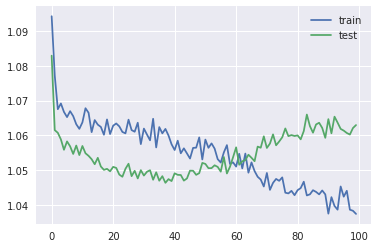

In [75]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

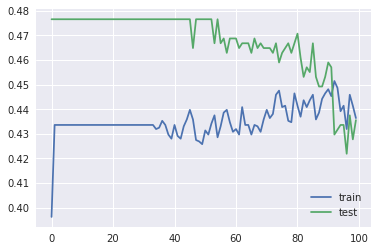

In [76]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

In [ ]:
predict_Y=model.predict(x=test_X,batch_size=batch_size)

In [ ]:
predict_Y.shape

In [ ]:
predict_value = np.argmax(predict_Y,axis=2)

In [ ]:
predict_value.shape

In [ ]:
test_set = idx300n.iloc[1800:2400, :].copy()

In [ ]:
test_set.head()

In [ ]:
def class_argmax(x):
    return np.argmax(x)

In [ ]:
test_set['class']= test_set['class'].map(class_argmax)

In [ ]:
test_set.head()

In [ ]:
cmp_predict = pd.DataFrame()
cmp_predict['class'] = test_set['class']

In [ ]:
cmp_predict['predict_class'] = predict_value.reshape((-1, ))

In [ ]:
cmp_predict['close'] = idx300.loc[cmp_predict.index, 'close']

In [ ]:
cmp_predict['diff'] = cmp_predict['predict_class'] - cmp_predict['class']

In [ ]:
cmp_predict.head()

In [ ]:
cmp_predict=cmp_predict.reset_index()

In [ ]:
cmp_predict = cmp_predict.reset_index()

In [ ]:
cmp_predict.head()

In [ ]:
def color(x):
    c = 'm'
    if x < 0:
        c = 'g'
    elif x > 0:
        c = 'r'
    else:
        c = 'b'
    return c
cmp_predict['color'] = cmp_predict['diff'].map(color)

In [ ]:
cmp_predict.plot(kind='scatter', x='index', y='close', s=60, c=cmp_predict.color, figsize=(21, 7))

In [ ]:
idx300n['close'].head(600).plot.hist( bins=30, figsize=(21, 7))

In [ ]:
cmp_predict.tail()

In [ ]:
cmp_predict['predict_class'].plot.hist()

In [ ]:
cmp_predict['class'].plot.hist()

In [ ]:
cmp_predict['next_close'] = cmp_predict['close'].shift(-1)

In [ ]:
cmp_predict['profit'] = cmp_predict['next_close'] - cmp_predict['close']

In [ ]:
cmp_predict.head()

In [ ]:
def predict_profit(x):
    profit = 0
    if x['predict_class'] == 2:
        profit = x['profit']
    elif x['predict_class'] == 0:
        profit = -x['profit']
    else:
        profit = 0
    return profit
cmp_predict['predict_profit'] = cmp_predict.apply(predict_profit, axis=1)

In [ ]:
cmp_predict['predict_profit'].cumsum().plot(figsize=(21, 7))

In [ ]:
cmp_predict.head(400).tail()

In [ ]:
cmp_predict.head()

In [ ]:
cmp_predict[cmp_predict['predict_class']==2]['predict_profit'].cumsum().plot(figsize=(21, 7))

In [ ]:
cmp_predict[cmp_predict['predict_class']==0]['predict_profit'].cumsum().plot(figsize=(21, 7))